In [1]:
!gdown --id 17hm4OL74_zRcWT2kwwqJyrALCEIinPcM

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17hm4OL74_zRcWT2kwwqJyrALCEIinPcM
To: /content/Training Data.csv
100% 20.1M/20.1M [00:00<00:00, 47.8MB/s]


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")

In [4]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'
colors = ['teal', 'darkorange', 'darkblue','maroon']

In [5]:
df = pd.read_csv('Training Data.csv')
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


# Business Understanding

1. Problem dari dataset
* Tingginya angka pinjaman
* Tingginya angka gagal bayar
* Staff yang terbatas

2. Sebagai siapa kalian pada dataset tersebut? Data scientist di DataTrust Consultant

3. Goal yang ingin dicapai
* Meningkatkan akurasi dalam persetujuan pinjaman
* Meningkatkan efisiensi dalam mengevaluasi pinjaman untuk mendukung staf yang terbatas

4. Objective yang sesuai dengan goal
* Mengembangkan model untuk memprediksi pinjaman yang beresiko
* Mengembangkan model untuk menghindari bias dan mendukung keputusan pemberian pinjaman yang akurat

5. Business metrics untuk mengukur ketercapaian Objective
* Approval Rate Optimization: Mengoptimalkan persetujuan pinjaman dan meminimalkan risiko
* Cost-to-Income Ratio: Banyak biaya yang dikeluarkan untuk menghasilkan pendapatan
* Non-Performing Loan (NPL) Reduction Rate: Mengurangi pinjaman beresiko
* Cycle Time Optimization: Meningkatkan efektivitas waktu proses loan assessment

# Exploratory Data Analysis

Penjelasan fitur:
1. **Id**: Identifikasi unik untuk setiap peminjam.  
2. **Income**: Pendapatan tahunan peminjam (nilai numerik dalam satuan mata uang).  
3. **Age**: Usia peminjam dalam tahun.  
4. **Experience**: Jumlah tahun pengalaman kerja profesional.  
5. **Married/Single**: Status pernikahan (Menikah atau Lajang).  
6. **House_Ownership**: Jenis kepemilikan rumah (Milik, Sewa, atau Tidak Sewa dan Tidak Milik).  
7. **Car_Ownership**: Apakah peminjam memiliki mobil (Ya atau Tidak).  
8. **Profession**: Pekerjaan atau profesi peminjam.  
9. **CITY**: Kota tempat tinggal peminjam.  
10. **STATE**: Provinsi tempat tinggal peminjam.  
11. **CURRENT_JOB_YRS**: Jumlah tahun bekerja di pekerjaan saat ini.  
12. **CURRENT_HOUSE_YRS**: Jumlah tahun tinggal di rumah saat ini.  
13. **Risk_Flag**: Variabel target – bernilai **1** jika peminjam berisiko gagal bayar, dan **0** jika tergolong risiko rendah.

In [7]:
df['Id'] = df['Id'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  object
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 25.0+ MB


In [8]:
cats= ['Id','Married/Single','House_Ownership','Car_Ownership','Profession','CITY','STATE']
nums=['Income','Age','Experience','CURRENT_JOB_YRS','CURRENT_HOUSE_YRS','Risk_Flag']

# General Info

In [9]:
df.describe()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


In [10]:
df[cats].describe()

,Id,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE
count,252000,252000,252000,252000,252000,252000,252000
unique,252000,2,3,2,51,317,29
top,251984,single,rented,no,Physician,Vijayanagaram,Uttar_Pradesh
freq,1,226272,231898,176000,5957,1259,28400


# Checking Empty and duplicated data

In [11]:
df.isnull().sum()

,0
Id,0
Income,0
Age,0
Experience,0
Married/Single,0
House_Ownership,0
Car_Ownership,0
Profession,0
CITY,0
STATE,0


In [12]:
df.duplicated().sum()

np.int64(0)

**Data Insight**

1. Kolom Id memiliki tipe data yang tidak tepat (Integer), sehingga diubah menjadi string
2. Total data dari dataset adalah 252.000 dan tidak ada data yang hilang atau duplikat

# Univariate Analysis

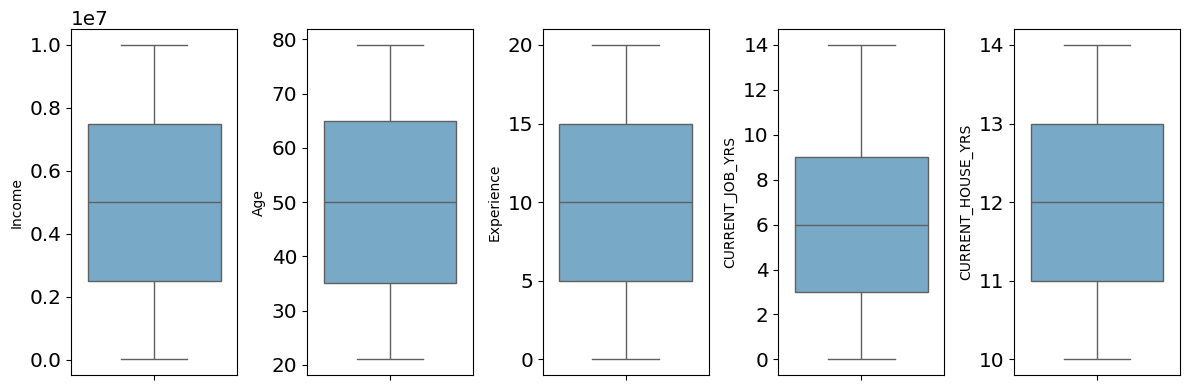

In [13]:
for i in range(0, len(nums[:-1])):
    plt.subplot(1, len(nums[:-1]), i+1)
    sns.boxplot(y=df[nums[:-1][i]], orient='v', palette='Blues')
    plt.tight_layout()

**Data Insight**

Kolom Income, Age, Experience, CURRENT_JOB_YRS, dan CURRENT_HOUSE_YRS tidak memiliki outlier. Ini menunjukkan data terdistribusi dengan baik tanpa nilai ekstrem

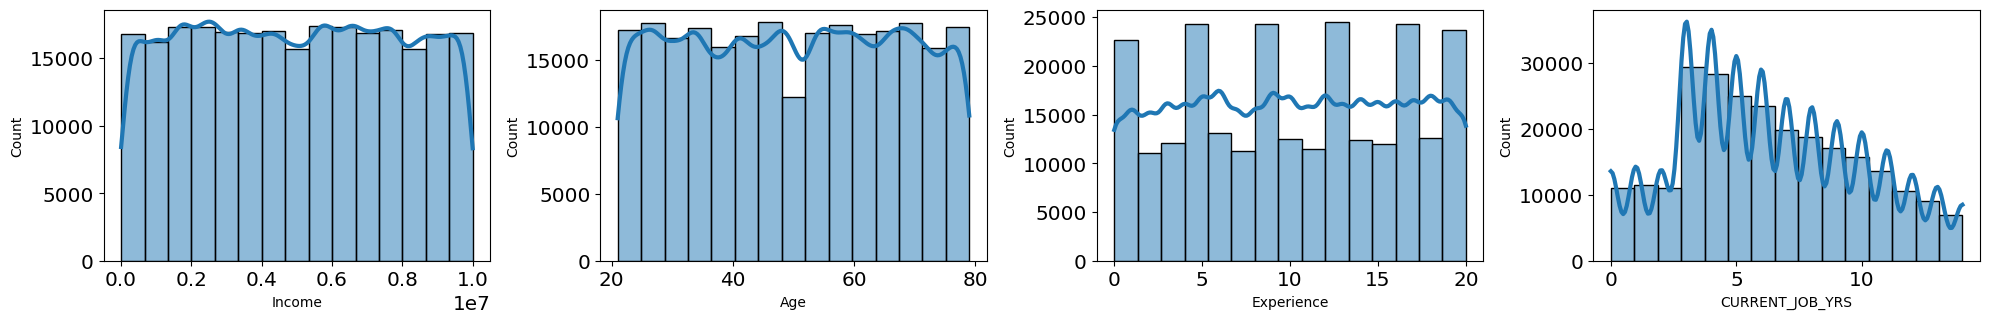

In [14]:
plt.figure(figsize=(20,6))
for i in range(0, len(nums[:-2])):
    plt.subplot(2, len(nums[:-2]), i+1)
    sns.histplot(df[nums[:-2][i]], bins=15, kde=True, palette='Blues')
    plt.tight_layout()

**Data Insight**
1. Kolom Income, Age, dan Experience memiliki distribusi normal
2. Kolom CURRENT_JOB_YRS memiliki distribusi positive skewness

<Axes: xlabel='CURRENT_HOUSE_YRS', ylabel='count'>

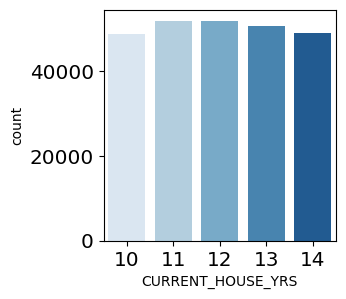

In [15]:
plt.figure(figsize=(3,3))
sns.countplot(x=df['CURRENT_HOUSE_YRS'], palette='Blues')

**Data Insight**

Lebih dari 40.000 peminjam sudah tinggal di rumahnya saat ini untuk rentang 10-14 tahun, dimana jumlah peminjam untuk setiap kategori tahun cukup seimbang

In [16]:
def compute_distribution(df, col):

    """
    Utility function to check data distribution for numerical features.

    mean >  median : Positive (Right) Skewed
    mean <  median : Negative (Left) Skewed
    mean == median : Normal

    skew in range (-0.5, 0.5) = approximately symmetrical (Normal distribution)
    skew in range (-1, 1) = moderately skewed
    skew > 1 or skew < -1 = highly skewed

    kurtosis > 3 : Leptokurtic
    kurtosis == 3: Mesokurtic
    kurtosis < 3: Platykurtic

    :param df: pandas dataframe
    :param col: selected numerical feature (string)
    :return: type of distribution (string)
    """

    mean = df[col].mean()
    median = df[col].median()

    skew_score = df[col].skew()
    kurtosis_score = df[col].kurtosis()

    if (skew_score > -0.5) and (skew_score < 0.5):
        skewness = 'Approximately Symmetric'
    elif (skew_score > -1) and (skew_score < 1):
        skewness = 'Moderately Skewed'
    else:
        skewness = 'Highly Skewed'

    if kurtosis_score > 3:
        kurtosis_flag = 'Leptokurtic'
    elif kurtosis_score == 3:
        kurtosis_flag = 'Mesokurtic'
    else:
        kurtosis_flag = 'Platykurtic'

    if mean < median:

        print(f'{col} data distribution: Left Skewed Distribution')
        print(f'Skewness score: {df[col].skew():.2f} [{skewness}]')
        print('--------------------------------------')

    elif mean > median:

        print(f'{col} data distribution: Right Skewed Distribution')
        print(f'Skewness score: {df[col].skew():.2f} [{skewness}]')
        print('--------------------------------------')

    else:

        print(f'{col} data distribution: Normal Distribution')
        print(f'Skewness score: {df[col].skew():.2f} [{skewness}]')
        print('--------------------------------------')

In [17]:
for i in nums[:-2]:
    compute_distribution(df, col=i)

Income data distribution: Left Skewed Distribution
Skewness score: 0.01 [Approximately Symmetric]
--------------------------------------
Age data distribution: Left Skewed Distribution
Skewness score: -0.01 [Approximately Symmetric]
--------------------------------------
Experience data distribution: Right Skewed Distribution
Skewness score: -0.01 [Approximately Symmetric]
--------------------------------------
CURRENT_JOB_YRS data distribution: Right Skewed Distribution
Skewness score: 0.27 [Approximately Symmetric]
--------------------------------------


**Data Insight**

  Distribusi data mendekati distribusi normal

Text(0.5, 1.0, 'Risk Distribution')

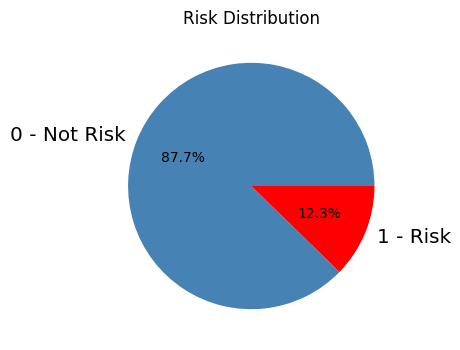

In [18]:
# Define mapping for Risk_Flag
risk_mapping = {0: "0 - Not Risk", 1: "1 - Risk"}

# Create the pie chart
plt.pie(df['Risk_Flag'].value_counts().values,
        labels=[risk_mapping[label] for label in df['Risk_Flag'].value_counts().index],
        autopct='%0.1f%%', colors = ('steelblue','red'))
plt.title('Risk Distribution')


**Data Insight**

Mayoritas 87,7% peminjam diklasifikasikan sebagai "Tidak Beresiko", sementara hanya 12,3% yang termasuk dalam kategori "Beresiko". Hal ini penting untuk dipertimbangkan dalam model prediksi, karena model bisa bias terhadap kelas mayoritas

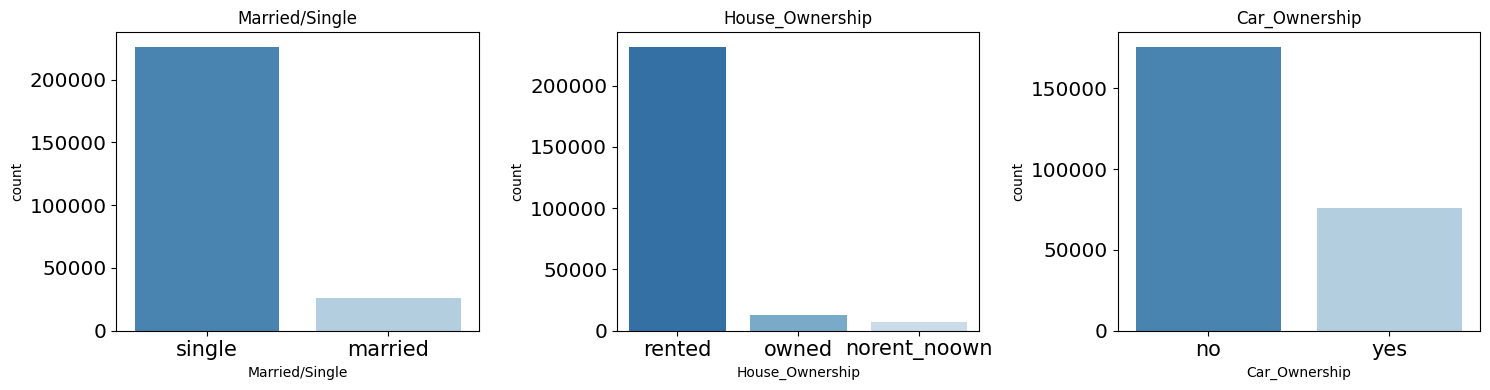

In [19]:
# Assuming cats is a list of column names
cols_to_plot = cats[1:4]

plt.figure(figsize=(15, 4))  # Adjust figure size for visibility

for i in range(len(cols_to_plot)):
    col = cols_to_plot[i]
    plt.subplot(1, len(cols_to_plot), i+1)

    # Get sorted categories based on frequency for consistent color mapping
    value_counts = df[col].value_counts()
    sorted_categories = value_counts.index

    # Create reversed palette and map to categories
    palette = sns.color_palette("Blues_r", n_colors=len(sorted_categories))
    color_dict = dict(zip(sorted_categories, palette))

    # Plot
    sns.countplot(x=col, data=df, palette=color_dict, order=sorted_categories)
    plt.title(col)
    plt.xticks(fontsize=15)

plt.tight_layout()

plt.show()

**Data Insight**

Mayoritas peminjam adalah single, menyewa rumah, dan tidak memiliki mobil

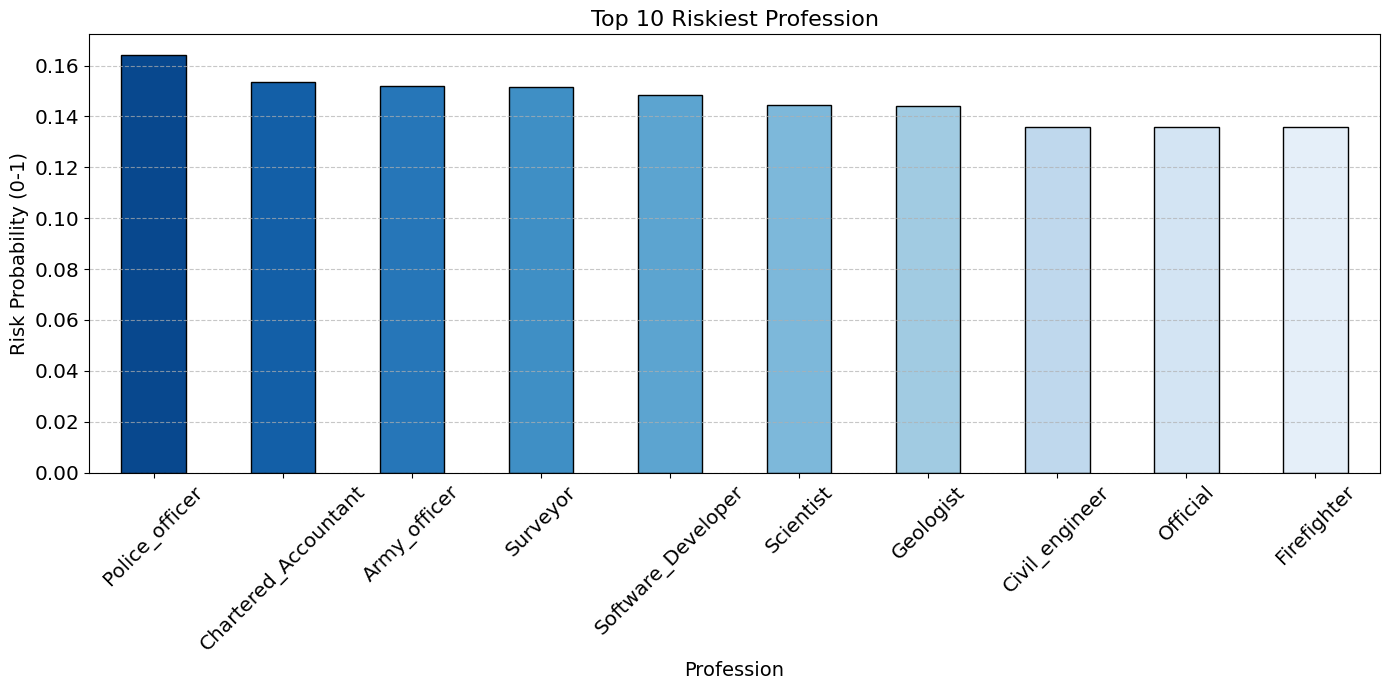

In [20]:
# Calculate mean risk by profession and sort
risk_by_profession = df.groupby('Profession')['Risk_Flag'].mean().sort_values(ascending=False)
top_risky_profession = risk_by_profession.head(10)

# Create reversed palette so darkest blue = highest risk
palette = sns.color_palette("Blues_r", n_colors=10)

# Map top professions to colors
colors = dict(zip(top_risky_profession.index, palette))
bar_colors = [colors[prof] for prof in top_risky_profession.index]

# Plot
plt.figure(figsize=(14, 7))
top_risky_profession.plot(kind='bar', color=bar_colors, edgecolor='black')
plt.title('Top 10 Riskiest Profession', fontsize=16)
plt.xlabel('Profession', fontsize=14)
plt.ylabel('Risk Probability (0-1)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Data Insight**  
Police officer, Chartered accountant, Education administrator, Army officer → Top professions with the highest risk probability.

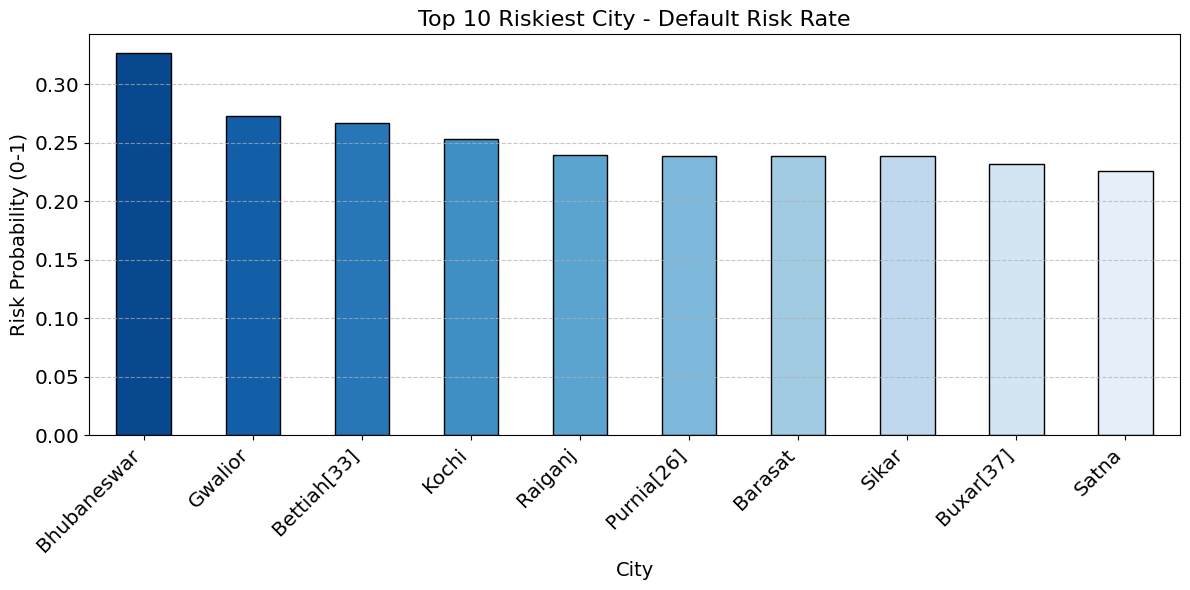

In [21]:
risk_by_city = df.groupby('CITY')['Risk_Flag'].mean().sort_values(ascending=False)
top_risky = risk_by_city.head(10)

# Create reversed palette so darkest blue = highest risk
palette = sns.color_palette("Blues_r", n_colors=10)

# Map top professions to colors
colors = dict(zip(top_risky_profession.index, palette))
bar_colors = [colors[prof] for prof in top_risky_profession.index]

plt.figure(figsize=(12,6))
top_risky.plot(kind='bar', color=bar_colors, edgecolor='black')
plt.title('Top 10 Riskiest City - Default Risk Rate', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Risk Probability (0-1)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Data Insight**  
Bhubaneswar, Gwalior, and Bettiah are the top three cities with the highest default risk probabilities, exceeding 25%.

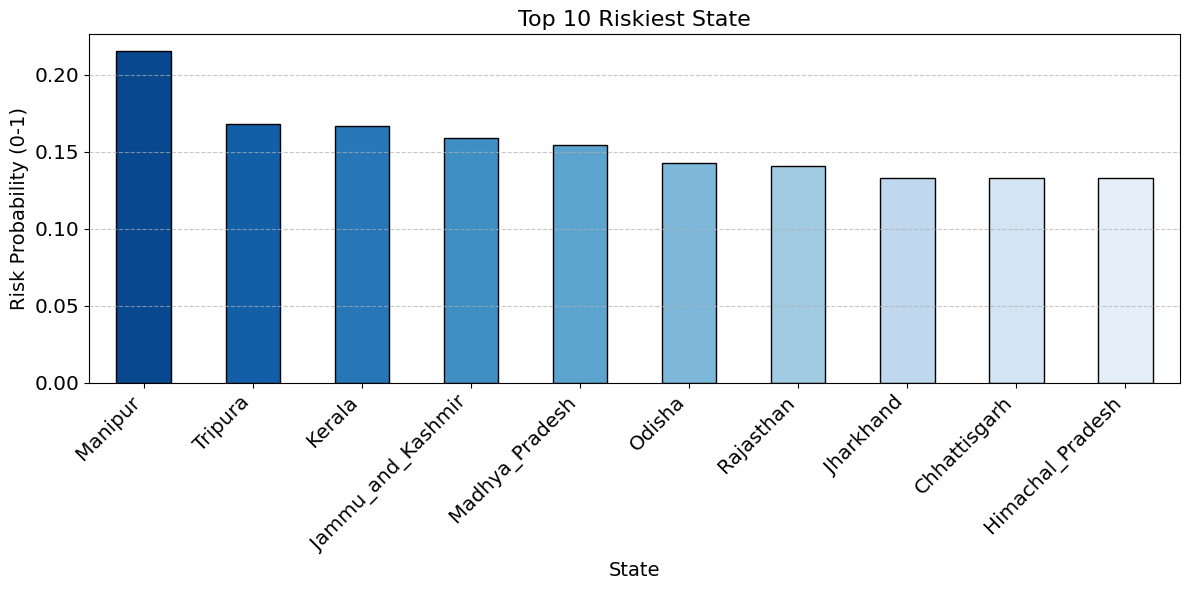

In [22]:
risk_by_state = df.groupby('STATE')['Risk_Flag'].mean().sort_values(ascending=False)

top_risky_state = risk_by_state.head(10)


plt.figure(figsize=(12,6))
top_risky_state.plot(kind='bar', color=bar_colors, edgecolor='black')
plt.title('Top 10 Riskiest State', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Risk Probability (0-1)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Data Insight**  
Manipur, Tripura, and Kerala as the top three states with the highest default risk probabilities, with Manipur standing out at over 21% risk.

# Multivariate Analysis

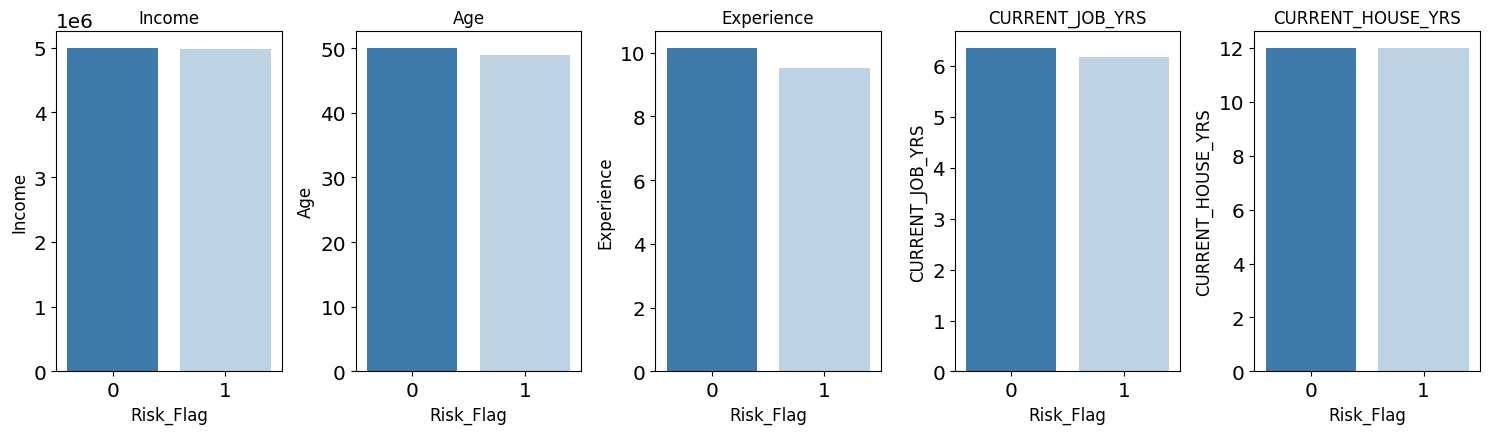

In [23]:
plt.figure(figsize=(15, 8))
for i in range(0, len(nums[:-1])):
    plt.subplot(2, len(nums[:-1]), i+1)
    palette = sns.color_palette("Blues", n_colors=9)
    sns.barplot(x="Risk_Flag", y=nums[i], data=df, estimator=np.mean, errorbar=None, palette=[palette[6], palette[2]])
    plt.title(f'{nums[i]}', fontsize=12)
    plt.ylabel(nums[i],fontsize=12)
    plt.xlabel('Risk_Flag',fontsize=12)
    plt.xticks(rotation = 0)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

**Data Insight**

Semua variabel (Income, Age, Experience, CURRENT_JOB_YRS, CURRENT_HOUSE_YRS) tidak menunjukkan perbedaan signifikan antara kelompok Risk dan Not Risk, sehingga bukan menjadi indikator kuat dalam mempengaruhi resiko

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100'),
  Text(120.0, 0, '120')])

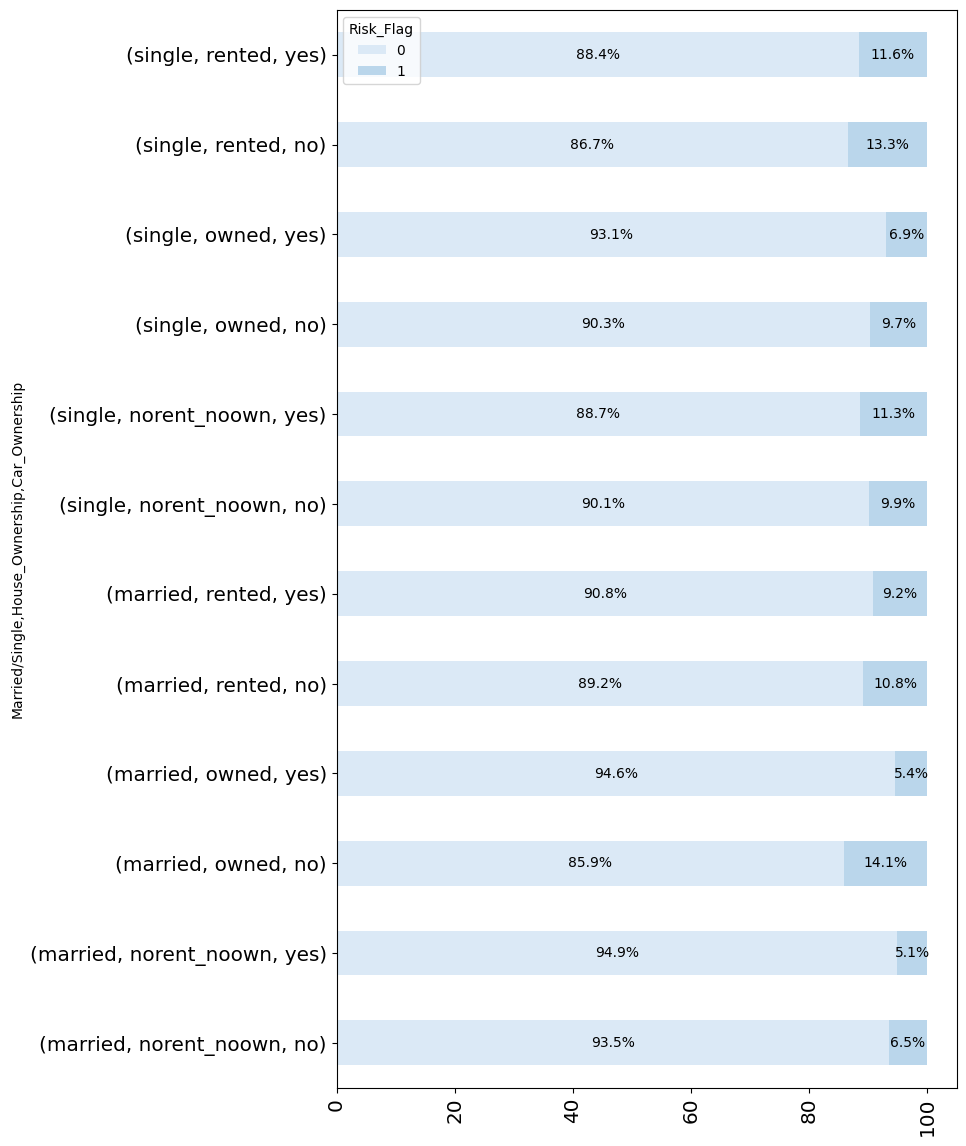

In [24]:
dfi = df.groupby(['Married/Single','House_Ownership','Car_Ownership','Risk_Flag'])['Id'].count().reset_index().rename(columns={'Id':'Total Customer'})
dfi['Percentage']=dfi.groupby(['Married/Single','House_Ownership','Car_Ownership'])['Total Customer'].transform(lambda x: round((x / x.sum()) * 100, 2))
dfpiv= dfi.pivot_table(index=['Married/Single','House_Ownership','Car_Ownership'], columns='Risk_Flag', values='Percentage')
colors = sns.color_palette("Blues")
av = dfpiv.plot(kind="barh", stacked=True, figsize=(8,14), color=colors)
for bars in av.containers:
    av.bar_label(bars, fmt="%.1f%%", label_type="center", color="black")
plt.xticks(rotation = 90)

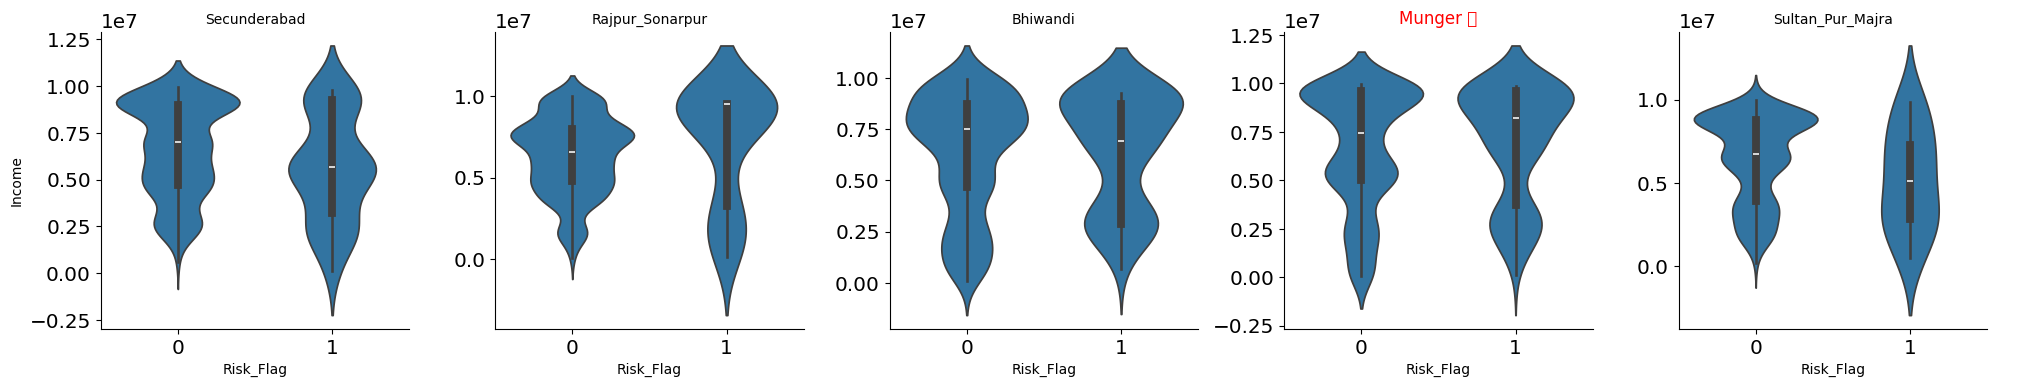

In [25]:
avg_income_per_city = df.groupby('CITY')['Income'].mean().sort_values(ascending=False)
top10_cities = avg_income_per_city.head(5).index


df_top10 = df[df['CITY'].isin(top10_cities)]


g = sns.catplot(
    data=df_top10,
    x="Risk_Flag", y="Income",
    col="CITY", col_wrap=5,
    kind="violin",
    sharey=False,
    height=4, aspect=1
)

top_city = avg_income_per_city.index[0]
g.set_titles(col_template="{col_name}" + (" 🔺" if "{col_name}" == top_city else ""))

for ax in g.axes.flatten():
    city = ax.get_title()
    if top_city in city:
        ax.set_title(f"{city} 🔺", color="red")

plt.subplots_adjust(top=0.9)
plt.show()

**Data Insight**

  Peminjam dengan resiko tertinggi merupakan seorang yg menikah, memiliki rumah namun tidak memiliki mobil.

## Chi Square Test

In [26]:
def chi_squared_test(df, cat1, cat2):

    """
    Conducting a Chi-Squared Hypothesis Test.
    :param df:
    :param cat1:
    :param cat2:
    :return:
    """
    print(f'{cat1} and {cat2}')
    contingency_table = pd.crosstab(df[cat1], df[cat2])
    res = stats.chi2_contingency(contingency_table)

    # interpret p-value
    alpha = 0.05
    print("p value is " + str(res.pvalue))
    if res.pvalue <= alpha:
        print(f"There is a significant relationship (dependency) between {cat1} and {cat2}")
    else:
        print(f'{cat1} and {cat2} are independent (no significant relationship).')
    print('--------------------------------------')

In [27]:
for i in cats[1:]:
  chi_squared_test(df, cat1=i, cat2='Risk_Flag')

Married/Single and Risk_Flag
p value is 3.773053705715196e-26
There is a significant relationship (dependency) between Married/Single and Risk_Flag
--------------------------------------
House_Ownership and Risk_Flag
p value is 1.8381930028370595e-40
There is a significant relationship (dependency) between House_Ownership and Risk_Flag
--------------------------------------
Car_Ownership and Risk_Flag
p value is 1.7350853850183746e-33
There is a significant relationship (dependency) between Car_Ownership and Risk_Flag
--------------------------------------
Profession and Risk_Flag
p value is 5.108641602000937e-98
There is a significant relationship (dependency) between Profession and Risk_Flag
--------------------------------------
CITY and Risk_Flag
p value is 0.0
There is a significant relationship (dependency) between CITY and Risk_Flag
--------------------------------------
STATE and Risk_Flag
p value is 2.0057472384130266e-136
There is a significant relationship (dependency) betwe

**Data Insight**

  Semua features kategorikal memiliki korelasi dengan column target Risk_flag.

## Anova

In [28]:
def compute_anova(df, nums, cats):
    print(f'Anova : {nums} and {cats}')

    # Example data
    unique_groups = df[cats].unique()

    # Create a list to store numerical values for each group
    groups = [df[df[cats] == group][nums] for group in unique_groups]

    # ANOVA test
    f_stat, p_value = f_oneway(*groups)

    print(f"F-statistic: {f_stat}, P-value: {p_value}")

    if p_value <= 0.05:
        print(f"{nums} among {cats}'s {len(unique_groups)} categories are significantly different")
    else:
        print(f"{nums} among {cats}'s {len(unique_groups)} categories are not significantly difference")
    print('--------------------------------------')

In [29]:
for i in nums[:-1]:
  compute_anova(df,nums=i,cats='Risk_Flag')

Anova : Income and Risk_Flag
F-statistic: 2.4079446287996715, P-value: 0.1207220319583281
Income among Risk_Flag's 2 categories are not significantly difference
--------------------------------------
Anova : Age and Risk_Flag
F-statistic: 119.91850679948466, P-value: 6.687623647499306e-28
Age among Risk_Flag's 2 categories are significantly different
--------------------------------------
Anova : Experience and Risk_Flag
F-statistic: 300.69230651920316, P-value: 2.5475634865752383e-67
Experience among Risk_Flag's 2 categories are significantly different
--------------------------------------
Anova : CURRENT_JOB_YRS and Risk_Flag
F-statistic: 72.34852624927743, P-value: 1.813221223267855e-17
CURRENT_JOB_YRS among Risk_Flag's 2 categories are significantly different
--------------------------------------
Anova : CURRENT_HOUSE_YRS and Risk_Flag
F-statistic: 4.823851147277152, P-value: 0.028069472774381213
CURRENT_HOUSE_YRS among Risk_Flag's 2 categories are significantly different
-------

**Data Insight**

  Income yang biasanya merupakan acuan utama penentu Risk_flag ternyata tidak memiliki korelasi dengan Risk_flag pada kasus ini. Feature ini dapat di drop dan dilakukan feature engineering berupa binning untuk tetap menggunakan informasinya.

<Axes: >

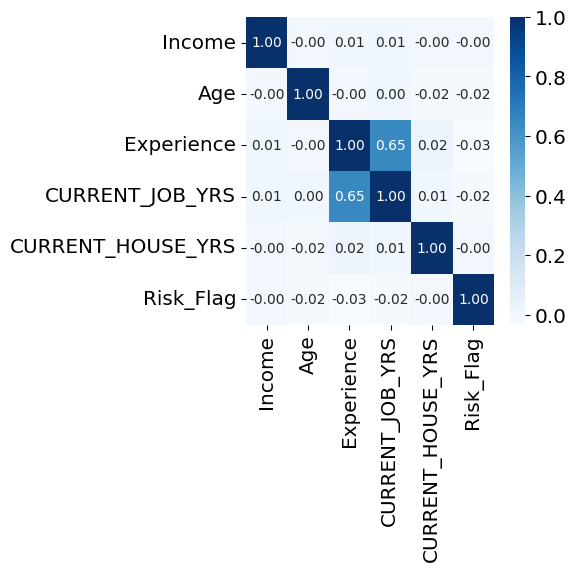

In [30]:
plt.figure(figsize=(4, 4))
sns.heatmap(df.select_dtypes(["float64", "int64", "boolean"]).corr(), cmap='Blues', annot=True, fmt='.2f', color=colors)

# Feature Engineering(New Feature)

### 1. Income Level

In [31]:
def categorize_income(income):
    if income < 125000:
        return 'Low'
    elif income < 500000 :
        return 'Lower-Middle'
    elif income < 3000000 :
        return 'Middle'
    else:
        return 'High'

# Apply the function
df['Income_Level'] = df['Income'].apply(categorize_income)

In [32]:
df.groupby('Income_Level')['Income'].agg(['min', 'max']).astype(int)

,min,max
Income_Level,,
High,3000077,9999938
Low,10310,124871
Lower-Middle,125676,499942
Middle,500098,2999973


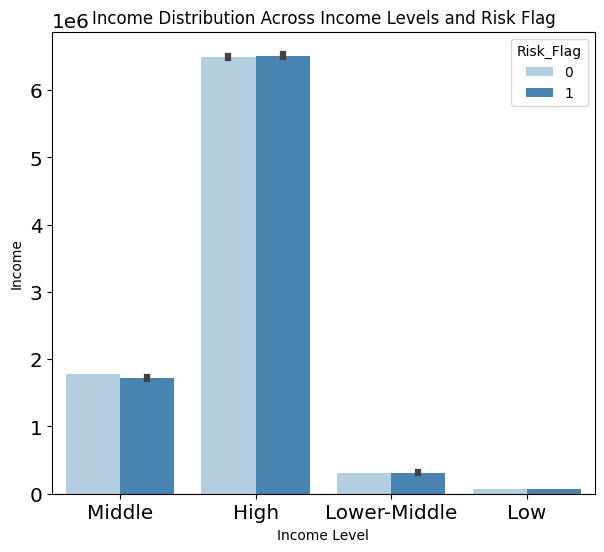

In [33]:
plt.figure(figsize=(7,6))
sns.barplot(x="Income_Level", y='Income', hue="Risk_Flag", data=df, palette='Blues')
plt.title('Income Distribution Across Income Levels and Risk Flag')
plt.xlabel('Income Level')
plt.legend(title='Risk_Flag')
plt.show()

In [34]:
chi_squared_test(df, cat1='Income_Level', cat2='Risk_Flag')

Income_Level and Risk_Flag
p value is 3.282943296408486e-11
There is a significant relationship (dependency) between Income_Level and Risk_Flag
--------------------------------------


**Data Insight**

  Income_level memiliki korelasi dengan Risk_flag dan dapat menjadi alternatif pengganti income yang tidak berkorelasi dengan Risk_flag

# Feature Encoding

### One-Hot Encoding

In [35]:
One_hot = ['Car_Ownership', 'Married/Single', 'House_Ownership']
for cat in One_hot:
    dummies = pd.get_dummies(df[cat], prefix=cat, drop_first=True)
    df = pd.concat([df, dummies], axis=1)

df.drop(columns=One_hot, inplace=True)

### Label Encoder

In [36]:
df['Income_Level'] = df['Income_Level'].map({'High': 3, 'Middle': 2, 'Lower-Middle': 1, 'Low': 0})

### Heatmap

<Axes: >

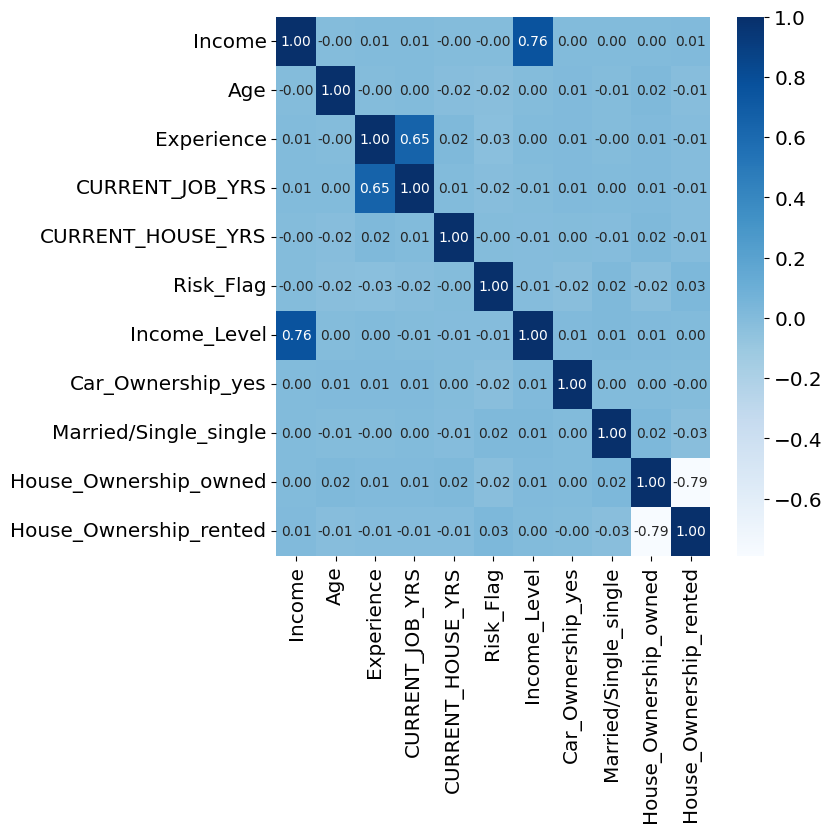

In [37]:
plt.figure(figsize=(7, 7))
sns.heatmap(df.select_dtypes(include=['int','bool']).corr(), cmap='Blues', annot=True, fmt='.2f')

In [38]:
# drop unnecessary
df.drop(['Id','Income'], axis=1, inplace=True)

# Split Data

In [39]:
X = df.drop(['Risk_Flag'], axis=1)
y = df['Risk_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
X_test_before = X_test.copy()

In [41]:
X_test_before.shape

(75600, 12)

In [42]:
def detect_outliers_iqr(X_train, column):
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = X_train[(X_train[column] < lower_bound) | (X_train[column] > upper_bound)]
    return outliers

In [43]:
nums = X_train.select_dtypes(["float64", "int64"]).columns

for col in nums:
    iqr_outliers = detect_outliers_iqr(X_train, col)

    if not iqr_outliers.empty:
        print(f"Outliers detected in {col}:")
        print("\n" + "-"*50 + "\n")  # Separator for better readability
    else:
        print(f"No outliers detected in {col}\n")

No outliers detected in Age

No outliers detected in Experience

No outliers detected in CURRENT_JOB_YRS

No outliers detected in CURRENT_HOUSE_YRS

Outliers detected in Income_Level:

--------------------------------------------------



In [44]:
print(f'Jumlah baris sebelum memfilter outlier: {len(X_train)}')

numeric_cols = X_train.select_dtypes(include=["float64", "int64"]).columns
X_train_numeric = X_train[numeric_cols]

Q1 = X_train_numeric.quantile(0.25)
Q3 = X_train_numeric.quantile(0.75)
IQR = Q3 - Q1

filtered = ~((X_train_numeric < (Q1 - 1.5 * IQR)) | (X_train_numeric > (Q3 + 1.5 * IQR))).any(axis=1)

# Apply the filter to full X_train and y_train
X_train = X_train[filtered]
y_train = y_train[filtered]

print(f'Jumlah baris setelah memfilter outlier: {len(X_train)}')

Jumlah baris sebelum memfilter outlier: 176400
Jumlah baris setelah memfilter outlier: 174489


**Data Insight**

  Tidak terdapat outliers pada data.

#Target Encoding (Profession,City,State)

In [45]:
def target_encode_columns(X_train, X_test, y_train, columns_to_encode):

    train = X_train.copy()
    test = X_test.copy()
    train['Risk_Flag'] = y_train

    overall_mean = y_train.mean()

    for col in columns_to_encode:
        # Calculate mean target encoding on training data
        target_mean = train.groupby(col)['Risk_Flag'].mean()

        # Map to train and test
        train[f'{col}_encoded'] = train[col].map(target_mean)
        test[f'{col}_encoded'] = test[col].map(target_mean)

        # Fill unseen categories in test
        test[f'{col}_encoded'].fillna(overall_mean, inplace=True)

        # Drop original categorical column
        train.drop(columns=[col], inplace=True)
        test.drop(columns=[col], inplace=True)

    # Drop Risk_Flag from train
    X_train = train.drop(columns='Risk_Flag')
    X_test = test

    return X_train, X_test

In [46]:
columns_to_encode = ['Profession', 'STATE', 'CITY']

X_train, X_test = target_encode_columns(X_train, X_test, y_train, columns_to_encode)

In [47]:
X_train

,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Income_Level,Car_Ownership_yes,Married/Single_single,House_Ownership_owned,House_Ownership_rented,Profession_encoded,STATE_encoded,CITY_encoded
8166,40,12,11,11,3,True,True,False,True,0.155452,0.157112,0.168196
84279,72,1,1,11,3,False,True,False,True,0.131892,0.102019,0.112069
37928,26,5,3,14,3,False,True,False,True,0.131183,0.126900,0.092308
153707,79,15,13,13,3,False,False,False,True,0.134522,0.131201,0.120654
63484,31,20,7,12,3,True,True,False,True,0.135230,0.117361,0.129964
...,...,...,...,...,...,...,...,...,...,...,...,...
119879,59,1,1,12,2,True,True,False,True,0.155452,0.170507,0.222609
103694,51,20,7,10,3,False,False,False,True,0.132880,0.117888,0.123145
131932,25,5,5,10,3,False,True,False,True,0.134522,0.141115,0.157009
146867,40,2,2,14,3,True,True,False,True,0.108774,0.117361,0.098196


In [48]:
Unscaling_data = X_test.copy()

In [49]:
y_train.dtype

dtype('int64')

In [50]:
# Check Multicollinearity
combine = pd.concat([X_train, y_train], axis=1)

In [51]:
combine

,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Income_Level,Car_Ownership_yes,Married/Single_single,House_Ownership_owned,House_Ownership_rented,Profession_encoded,STATE_encoded,CITY_encoded,Risk_Flag
8166,40,12,11,11,3,True,True,False,True,0.155452,0.157112,0.168196,0
84279,72,1,1,11,3,False,True,False,True,0.131892,0.102019,0.112069,0
37928,26,5,3,14,3,False,True,False,True,0.131183,0.126900,0.092308,0
153707,79,15,13,13,3,False,False,False,True,0.134522,0.131201,0.120654,0
63484,31,20,7,12,3,True,True,False,True,0.135230,0.117361,0.129964,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,59,1,1,12,2,True,True,False,True,0.155452,0.170507,0.222609,1
103694,51,20,7,10,3,False,False,False,True,0.132880,0.117888,0.123145,0
131932,25,5,5,10,3,False,True,False,True,0.134522,0.141115,0.157009,0
146867,40,2,2,14,3,True,True,False,True,0.108774,0.117361,0.098196,0


<Axes: >

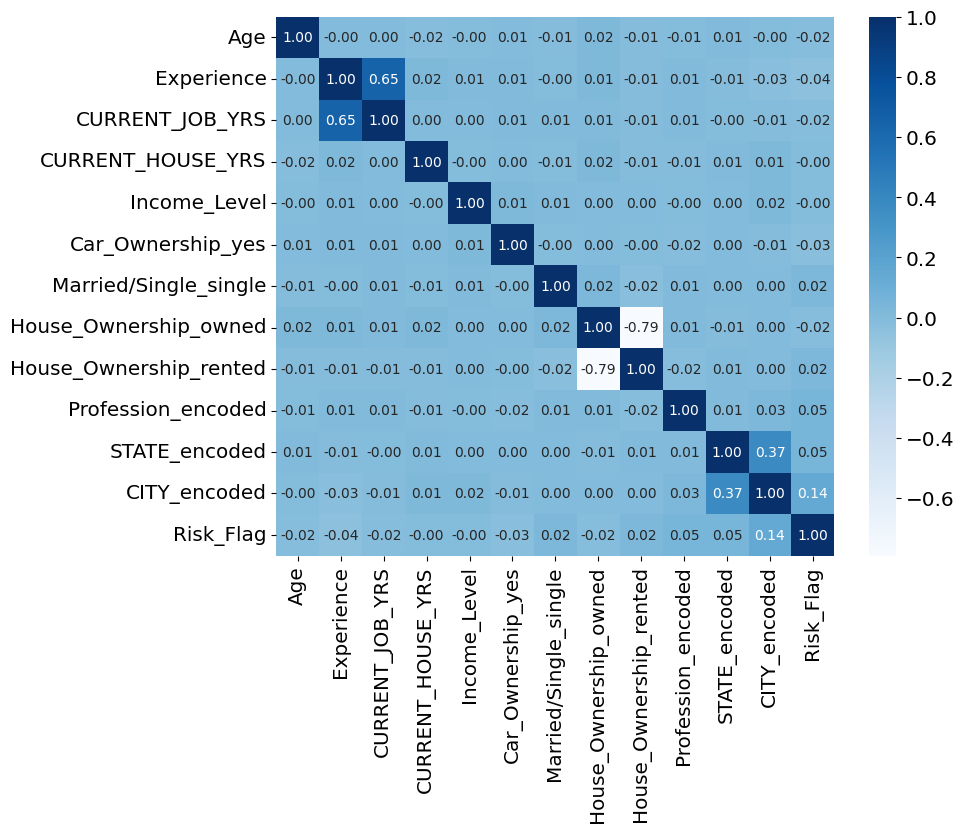

In [52]:
plt.figure(figsize=(9, 7))
sns.heatmap(combine.select_dtypes(include=['int','float','bool']).corr(), cmap='Blues', annot=True, fmt='.2f')

# Scaling

In [53]:
# List of numerical features
new_nums = X_train.columns.tolist()

scaler = StandardScaler()

# Fit the scaler on the entire X_train
X_train[new_nums] = scaler.fit_transform(X_train[new_nums])
# Use the same scaler to X_test
X_test[new_nums] = scaler.transform(X_test[new_nums])

# Feature Selection

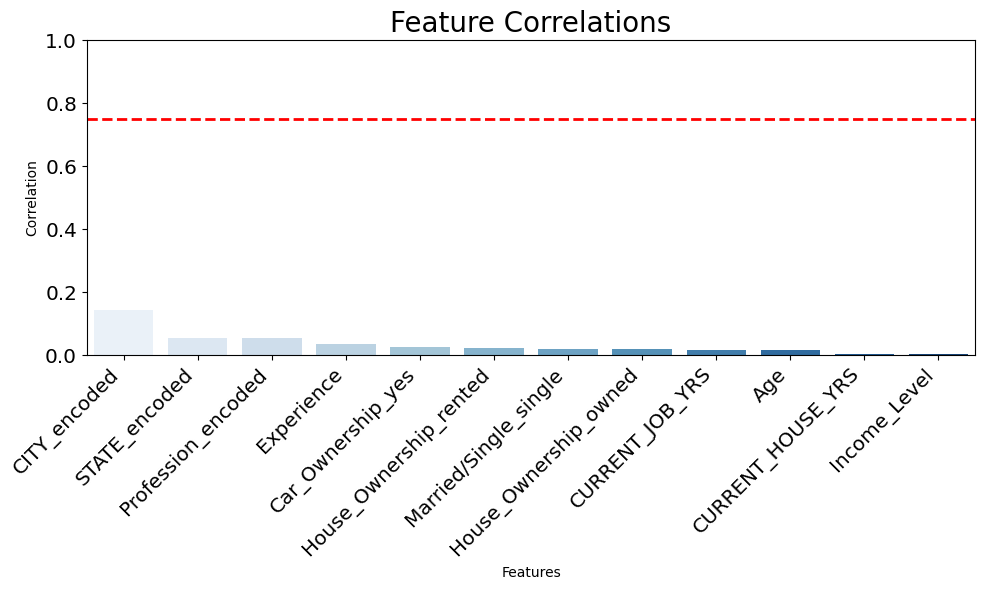

In [54]:
new_df = pd.concat([X_train, y_train], axis=1)
correlation = new_df.corr()["Risk_Flag"].drop("Risk_Flag").abs().sort_values(ascending=False)

# Create DataFrame for plotting
corr_df = correlation.reset_index()
corr_df.columns = ["Feature", "Correlation"]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=corr_df, x="Feature", y="Correlation", palette='Blues', label="Correlation value")

# Add threshold line (e.g., 0.75)
plt.axhline(y=0.75, color='red', linestyle='--', linewidth=2)

# Customize plot
plt.title("Feature Correlations", fontsize=20)
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

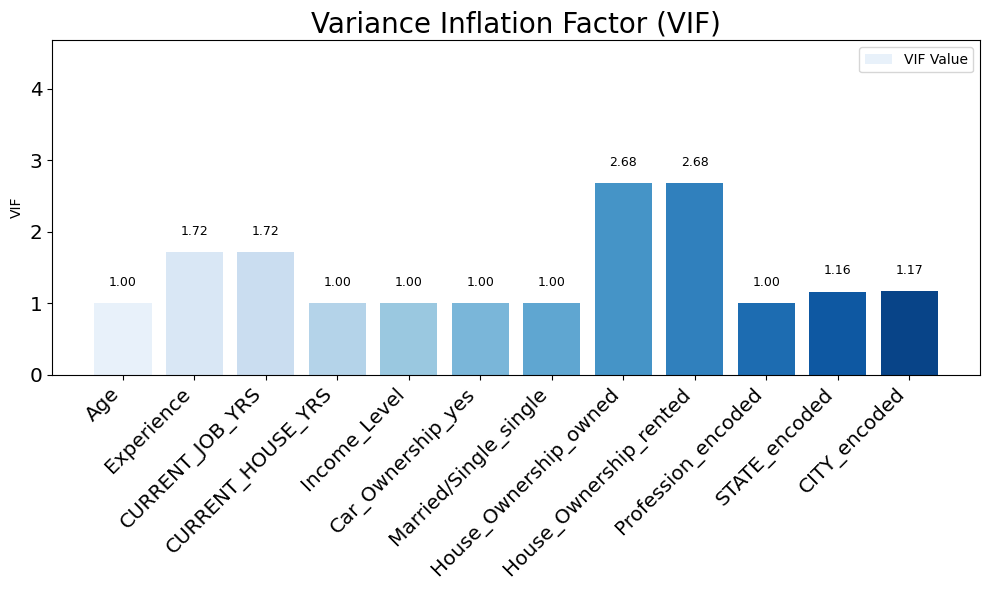

In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

vif_data = X_train.copy()  # Replace with your DataFrame
X = vif_data.select_dtypes(include=['int64', 'float64']).dropna()
X_const = add_constant(X)

# Step 2: Calculate VIF
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]

# Step 3: Cap VIF at 50 for plotting
vif["VIF_capped"] = vif["VIF"].clip(upper=50)

# Optional: Label VIFs (e.g., "50+" for capped values)
vif["Label"] = vif.apply(lambda x: f"{x['VIF']:.2f}" if x['VIF'] <= 50 else "50+", axis=1)

# Step 4: Plot
plt.figure(figsize=(10, 6))
color = sns.color_palette("Blues", n_colors=len(vif))
bars = plt.bar(vif["Feature"], vif["VIF_capped"], color=color, label="VIF Value")
plt.title("Variance Inflation Factor (VIF)", fontsize=20)
plt.ylabel("VIF")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, vif["VIF_capped"].max() + 2)

# Annotate VIF values on top of bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2,
             vif["Label"].iloc[i], ha='center', va='bottom', fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()


# Class Imbalance

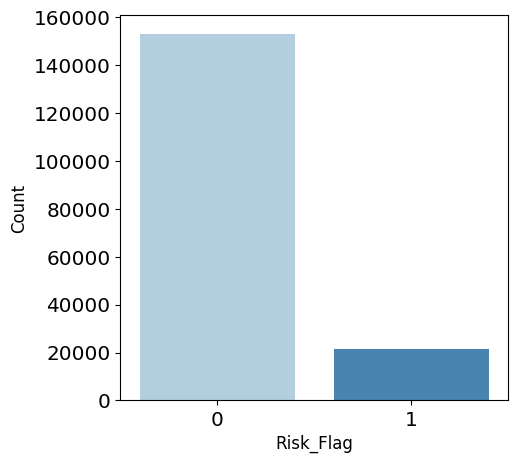

In [56]:
#Before UnderSampling
y_train_df = y_train.to_frame()
plt.figure(figsize=(5, 5))
sns.countplot(x="Risk_Flag", data=y_train_df, palette="Blues")
plt.xlabel('Risk_Flag', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.show()

In [57]:
df['Risk_Flag'].value_counts(normalize=True)

,proportion
Risk_Flag,
0,0.877
1,0.123


### UnderSampling

In [58]:
X_train.shape

(174489, 12)

In [59]:
rus = RandomUnderSampler(random_state=42)

X_train, y_train = rus.fit_resample(X_train, y_train)

In [60]:
y_train.value_counts(normalize=True)

,proportion
Risk_Flag,
0,0.5
1,0.5


In [61]:
X_train.shape

(42856, 12)

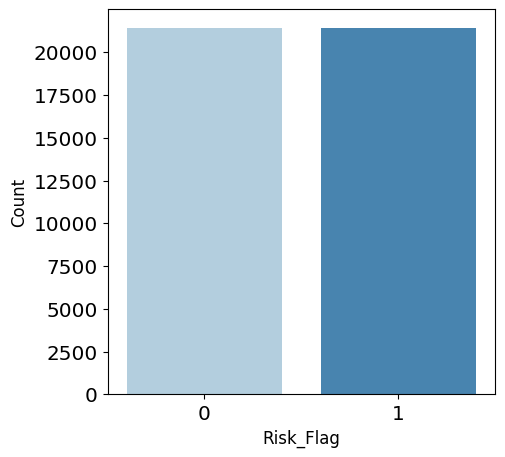

In [62]:
#After UnderSampling
y_train_after = y_train.to_frame()
plt.figure(figsize=(5, 5))
sns.countplot(x="Risk_Flag", data=y_train_after, palette="Blues")
plt.xlabel('Risk_Flag', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.show()

In [63]:
X_train

,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Income_Level,Car_Ownership_yes,Married/Single_single,House_Ownership_owned,House_Ownership_rented,Profession_encoded,STATE_encoded,CITY_encoded
192166,-0.528318,0.486293,-0.363405,-1.424930,0.608081,-0.656747,0.3369,-0.23263,0.293917,0.523330,-0.280159,-0.222479
44211,-1.699560,1.485074,2.101618,0.004152,-1.209536,1.522656,0.3369,-0.23263,0.293917,-0.040516,-0.310170,-1.455420
78085,1.169983,-0.678952,-0.089514,1.433234,0.608081,1.522656,0.3369,-0.23263,0.293917,-0.040516,-1.184455,-0.043973
2985,-0.996815,1.152147,2.101618,0.004152,-1.209536,1.522656,0.3369,-0.23263,0.293917,0.658331,-0.310170,-1.229248
172457,1.404231,1.651538,-0.089514,1.433234,0.608081,-0.656747,0.3369,-0.23263,0.293917,0.595438,0.563887,0.292573
...,...,...,...,...,...,...,...,...,...,...,...,...
84654,-1.582436,0.819220,1.006052,1.433234,-3.027153,-0.656747,0.3369,-0.23263,0.293917,-0.759094,-0.191870,-0.245515
235796,0.174427,-0.013098,1.006052,0.004152,-1.209536,1.522656,0.3369,-0.23263,0.293917,-0.621466,-0.310170,1.258952
194027,-1.406749,-0.013098,1.006052,0.004152,-1.209536,-0.656747,0.3369,4.29867,-3.402320,-1.073996,-0.667415,-0.635324
191335,-1.348187,-0.845415,-0.637297,0.004152,0.608081,1.522656,0.3369,-0.23263,0.293917,1.880146,0.560018,1.635090


# **Modeling**

Pemilihan recall karena pada kasus loan predict, menghindari false negative (yaitu diprediksi "low risk" padahal sebenarnya "high risk"). Memberikan peminjam yang sebenarnya berisiko tinggi gagal bayar dapat berdampak pada kerugian finansial langsung, dan bisa sangat besar apabila ajuan pinjamannya besar. Menolak pinjaman dari customer yang sebenarnya "tidak berisiko", dampaknya lebih ringan, karena hanya menyebabkan kehilangan potensi keuntungan (opportunity loss), bukan kerugian langsung.


In [ ]:
def eval_classification(model, model_name):
    model.fit(X_train, y_train)

    metrics = {"Model": model_name}

    # Predictions
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Basic metrics
    metrics["Recall Train"] = recall_score(y_train, y_pred_train)
    metrics["Recall Test"] = recall_score(y_test, y_pred_test)
    metrics["F1 Train"] = f1_score(y_train, y_pred_train)
    metrics["F1 Test"] = f1_score(y_test, y_pred_test)

    # Cross-validation
    score = cross_validate(model, X_train, y_train, cv=5, scoring='recall', return_train_score=True)
    metrics["Recall CV Train"] = score['train_score'].mean()
    metrics["Recall CV Test"] = score['test_score'].mean()

    return metrics

In [ ]:
results = []

models = {
    "LogisticRegression" : LogisticRegression(),
    "DecisionTreeClassifier" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(),
    "XGB" : XGBClassifier(),
    "Gaussian" : GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "AdaBoost" : AdaBoostClassifier(),
    "Ridge": RidgeClassifier(),
    "SGD": SGDClassifier(),
    "PassiveAggressive": PassiveAggressiveClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "ExtraTrees": ExtraTreesClassifier(),
    "LightGBM": LGBMClassifier(verbosity=-1),
    "CatBoost": CatBoostClassifier(verbose=False),
    "MLP" : MLPClassifier()
}

for name, model in models.items():
    metrics = eval_classification(model, model_name=name)
    results.append(metrics)

df_results = pd.DataFrame(results)
display(df_results.round(3))

,Model,Recall Train,Recall Test,F1 Train,F1 Test,Recall CV Train,Recall CV Test
0,LogisticRegression,0.572,0.562,0.586,0.262,0.572,0.572
1,DecisionTreeClassifier,0.999,0.865,0.960,0.577,0.999,0.867
2,RandomForest,0.999,0.806,0.960,0.609,0.999,0.803
3,XGB,0.870,0.817,0.868,0.525,0.875,0.814
4,Gaussian,0.689,0.689,0.622,0.251,0.689,0.687
5,KNN,0.716,0.679,0.799,0.512,0.764,0.741
6,AdaBoost,0.616,0.607,0.605,0.262,0.626,0.620
7,Ridge,0.571,0.559,0.585,0.262,0.570,0.569
8,SGD,0.606,0.604,0.595,0.256,0.540,0.541
9,PassiveAggressive,0.330,0.333,0.396,0.174,0.597,0.595


In [65]:
def eval_classification_single(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))

    # Use probabilities for roc_auc_score
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]

    print("ROC-AUC (Train Set): %.2f" % roc_auc_score(y_train, y_pred_proba_train))
    print("ROC-AUC (Test Set): %.2f" % roc_auc_score(y_test, y_pred_proba_test))

    score = cross_validate(model, X_train, y_train, cv=5, scoring='recall', return_train_score=True)
    print('Recall (crossval train): %.2f' % score['train_score'].mean())
    print('Recall (crossval test): %.2f' % score['test_score'].mean())

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix_and_metrics(model, labels=["Low Risk (0)", "Risk (1)"]):
    y_pred = model.predict(X_test)
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Plot
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

In [67]:
from sklearn.metrics import confusion_matrix

def analyze_fp_fn_balance(model):
    y_pred = model.predict(X_test)
    # Confusion matrix breakdown
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total = tn + fp + fn + tp

    # Percentages
    fp_pct = fp / total * 100
    fn_pct = fn / total * 100

    print(f"True Positives (TP): {tp} ({tp / total:.2%})")
    print(f"True Negatives (TN): {tn} ({tn / total:.2%})")
    print(f"False Positives (FP): {fp} ({fp_pct:.2f}%)")
    print(f"False Negatives (FN): {fn} ({fn_pct:.2f}%)")

    # FP vs FN Balance Ratio
    if (fp + fn) > 0:
        balance_ratio = abs(fp - fn) / (fp + fn)
        print(f"\n🔁 Balance between FP and FN (0 = perfect balance, 1 = completely unbalanced): {balance_ratio:.2f}")
    else:
        print("\nNo FP or FN to compare (perfect prediction).")

In [78]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
    feat_importances = feat_importances.nlargest(25)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=feat_importances.values, y=feat_importances.index, palette="Blues_r")

    plt.xlabel('Score')
    plt.ylabel('Features')
    plt.title('Features Importance Score')
    plt.show()

# Xgboost

## Base Model

In [ ]:
xgb_model = XGBClassifier(verbosity=0, random_state=42)

print(f'Evaluate model: XGBClassifier sebelum tuning')
eval_classification_single(xgb_model)

Evaluate model: XGBClassifier sebelum tuning
Recall (Train Set): 0.87
Recall (Test Set): 0.82
ROC-AUC (Train Set): 0.93
ROC-AUC (Test Set): 0.87
Recall (crossval train): 0.88
Recall (crossval test): 0.81


In [ ]:
import json

config = xgb_model.get_booster().save_config()
parsed = json.loads(config)
print(json.dumps(parsed, indent=2))

{
  "learner": {
    "generic_param": {
      "device": "cpu",
      "fail_on_invalid_gpu_id": "0",
      "n_jobs": "0",
      "nthread": "0",
      "random_state": "42",
      "seed": "42",
      "seed_per_iteration": "0",
      "validate_parameters": "1"
    },
    "gradient_booster": {
      "gbtree_model_param": {
        "num_parallel_tree": "1",
        "num_trees": "100"
      },
      "gbtree_train_param": {
        "process_type": "default",
        "tree_method": "auto",
        "updater": "grow_quantile_histmaker",
        "updater_seq": "grow_quantile_histmaker"
      },
      "name": "gbtree",
      "specified_updater": false,
      "tree_train_param": {
        "alpha": "0",
        "cache_opt": "1",
        "colsample_bylevel": "1",
        "colsample_bynode": "1",
        "colsample_bytree": "1",
        "eta": "0.300000012",
        "gamma": "0",
        "grow_policy": "depthwise",
        "interaction_constraints": "",
        "lambda": "1",
        "learning_rate": "

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def plot_confusion_matrix_and_metrics(model, labels=["Low Risk (0)", "Risk (1)"]):
    y_pred = model.predict(X_test)
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Plot
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

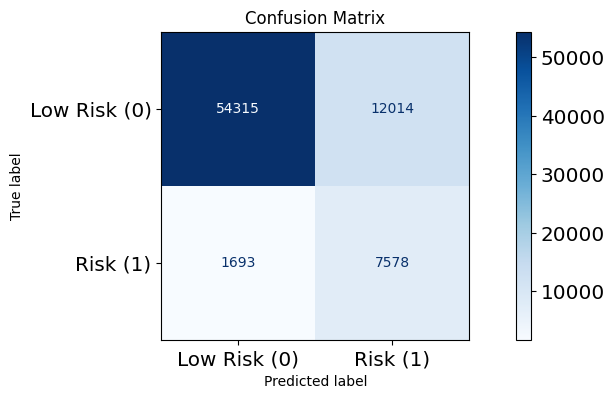

In [ ]:
plot_confusion_matrix_and_metrics(xgb_model)

In [ ]:
from sklearn.metrics import confusion_matrix

def analyze_fp_fn_balance(model):
    y_pred = model.predict(X_test)
    # Confusion matrix breakdown
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total = tn + fp + fn + tp

    # Percentages
    fp_pct = fp / total * 100
    fn_pct = fn / total * 100

    print(f"True Positives (TP): {tp} ({tp / total:.2%})")
    print(f"True Negatives (TN): {tn} ({tn / total:.2%})")
    print(f"False Positives (FP): {fp} ({fp_pct:.2f}%)")
    print(f"False Negatives (FN): {fn} ({fn_pct:.2f}%)")

    # FP vs FN Balance Ratio
    if (fp + fn) > 0:
        balance_ratio = abs(fp - fn) / (fp + fn)
        print(f"\n🔁 Balance between FP and FN (0 = perfect balance, 1 = completely unbalanced): {balance_ratio:.2f}")
    else:
        print("\nNo FP or FN to compare (perfect prediction).")

In [ ]:
analyze_fp_fn_balance(xgb_model)

True Positives (TP): 7578 (10.02%)
True Negatives (TN): 54315 (71.85%)
False Positives (FP): 12014 (15.89%)
False Negatives (FN): 1693 (2.24%)

🔁 Balance between FP and FN (0 = perfect balance, 1 = completely unbalanced): 0.75


In [ ]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
    feat_importances = feat_importances.nlargest(25)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=feat_importances.values, y=feat_importances.index, palette="Blues") # Changed to sns.barplot

    plt.xlabel('Score')
    plt.ylabel('Features')
    plt.title('Features Importance Score')
    plt.show()

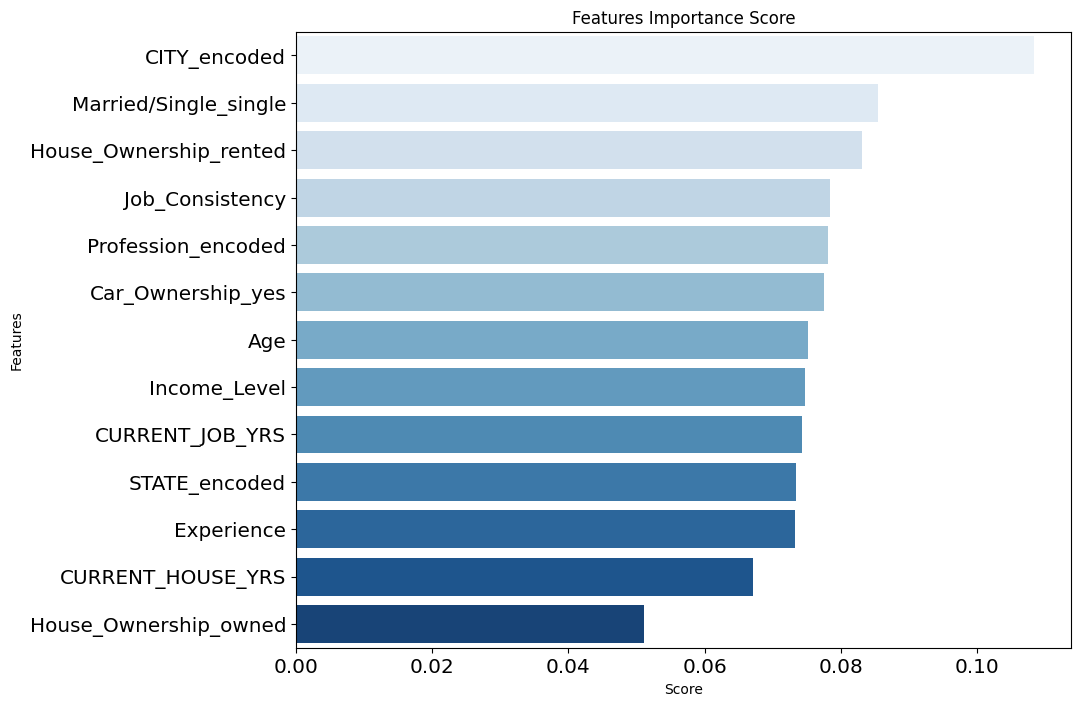

In [ ]:
show_feature_importance(xgb_model)

## Hyperparameter Tuning

### Learning Curve n_estimators

In [ ]:
def draw_xgb_curve_n_estimators(n_estimators):
    train_recall_scores = []
    test_recall_scores = []
    train_roc_scores = []
    test_roc_scores = []

    for i in n_estimators:
        model = XGBClassifier(verbose=0, n_estimators=i, random_state=42)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

        # Recall
        train_recall = recall_score(y_train, y_train_pred)
        test_recall = recall_score(y_test, y_test_pred)
        train_recall_scores.append(train_recall)
        test_recall_scores.append(test_recall)

        # ROCAUC-score
        train_roc = roc_auc_score(y_train, y_pred_proba_train)
        test_roc = roc_auc_score(y_test, y_pred_proba_test)
        train_roc_scores.append(train_roc)
        test_roc_scores.append(test_roc)

        print(f'n_estimators: {i:}; Recall Train: {train_recall:.4f}, Test: {test_recall:.4f}; '
              f'ROCAUC Train: {train_roc:.4f}, Test: {test_roc:.4f}')

    # Plot Recall
    plt.figure()
    plt.plot(n_estimators, train_recall_scores, label='Train Recall')
    plt.plot(n_estimators, test_recall_scores, label='Test Recall')
    plt.xlabel('n_estimators')
    plt.ylabel('Recall Score')
    plt.title('Recall vs n_estimators')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC-score
    plt.figure()
    plt.plot(n_estimators, train_roc_scores, label='Train ROC')
    plt.plot(n_estimators, test_roc_scores, label='Test ROC')
    plt.xlabel('n_estimators')
    plt.ylabel('ROCAUC Score')
    plt.title('ROCAUC Score vs n_estimators')
    plt.legend()
    plt.grid(True)
    plt.show()

n_estimators: 10; Recall Train: 0.6940, Test: 0.6713; ROCAUC Train: 0.7551, Test: 0.7286
n_estimators: 62; Recall Train: 0.8326, Test: 0.7905; ROCAUC Train: 0.9032, Test: 0.8520
n_estimators: 114; Recall Train: 0.8761, Test: 0.8198; ROCAUC Train: 0.9366, Test: 0.8757
n_estimators: 166; Recall Train: 0.9009, Test: 0.8290; ROCAUC Train: 0.9516, Test: 0.8861
n_estimators: 218; Recall Train: 0.9219, Test: 0.8296; ROCAUC Train: 0.9598, Test: 0.8918
n_estimators: 270; Recall Train: 0.9379, Test: 0.8321; ROCAUC Train: 0.9645, Test: 0.8961
n_estimators: 322; Recall Train: 0.9503, Test: 0.8351; ROCAUC Train: 0.9674, Test: 0.8987
n_estimators: 374; Recall Train: 0.9636, Test: 0.8336; ROCAUC Train: 0.9695, Test: 0.9006
n_estimators: 426; Recall Train: 0.9725, Test: 0.8368; ROCAUC Train: 0.9711, Test: 0.9024
n_estimators: 478; Recall Train: 0.9783, Test: 0.8366; ROCAUC Train: 0.9724, Test: 0.9033
n_estimators: 531; Recall Train: 0.9839, Test: 0.8387; ROCAUC Train: 0.9735, Test: 0.9042
n_estimators

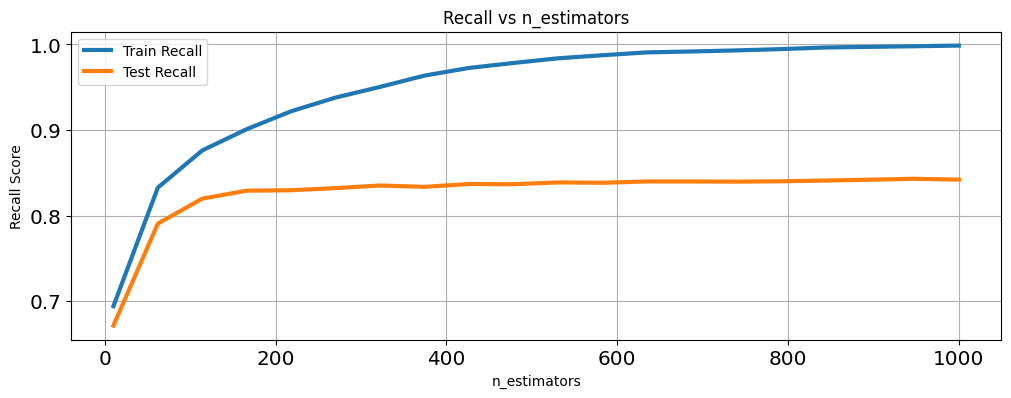

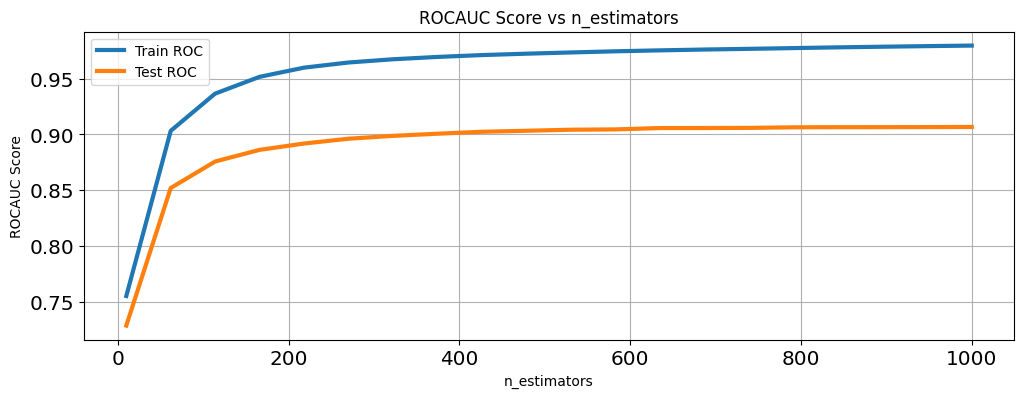

In [ ]:
n_estimators = [int(x) for x in np.linspace(10, 1000, 20)]
draw_xgb_curve_n_estimators(n_estimators)

n_estimators: 10; Recall Train: 0.6940, Test: 0.6713; ROCAUC Train: 0.7551, Test: 0.7286
n_estimators: 20; Recall Train: 0.7452, Test: 0.7150; ROCAUC Train: 0.8124, Test: 0.7755
n_estimators: 30; Recall Train: 0.7722, Test: 0.7389; ROCAUC Train: 0.8430, Test: 0.8026
n_estimators: 40; Recall Train: 0.7977, Test: 0.7602; ROCAUC Train: 0.8717, Test: 0.8270
n_estimators: 50; Recall Train: 0.8221, Test: 0.7818; ROCAUC Train: 0.8904, Test: 0.8415
n_estimators: 60; Recall Train: 0.8314, Test: 0.7876; ROCAUC Train: 0.9010, Test: 0.8497
n_estimators: 70; Recall Train: 0.8484, Test: 0.8044; ROCAUC Train: 0.9121, Test: 0.8585
n_estimators: 80; Recall Train: 0.8534, Test: 0.8088; ROCAUC Train: 0.9194, Test: 0.8642
n_estimators: 90; Recall Train: 0.8631, Test: 0.8151; ROCAUC Train: 0.9258, Test: 0.8688
n_estimators: 100; Recall Train: 0.8696, Test: 0.8174; ROCAUC Train: 0.9305, Test: 0.8713
n_estimators: 110; Recall Train: 0.8756, Test: 0.8187; ROCAUC Train: 0.9347, Test: 0.8741
n_estimators: 120; 

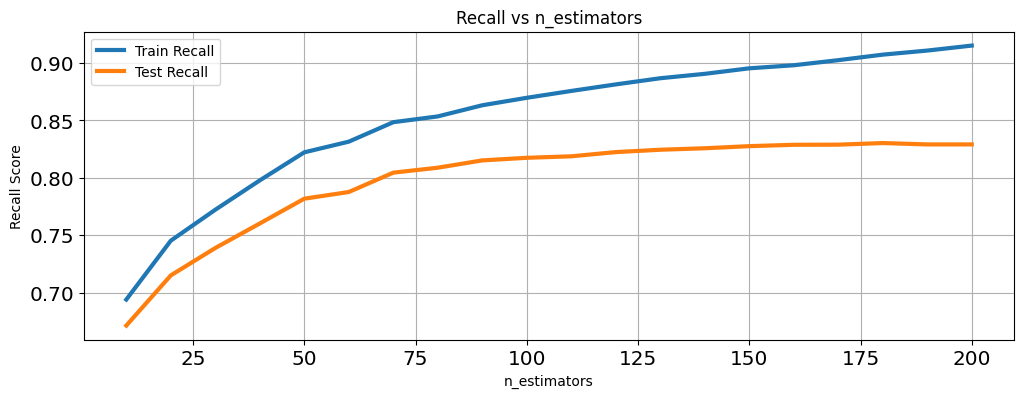

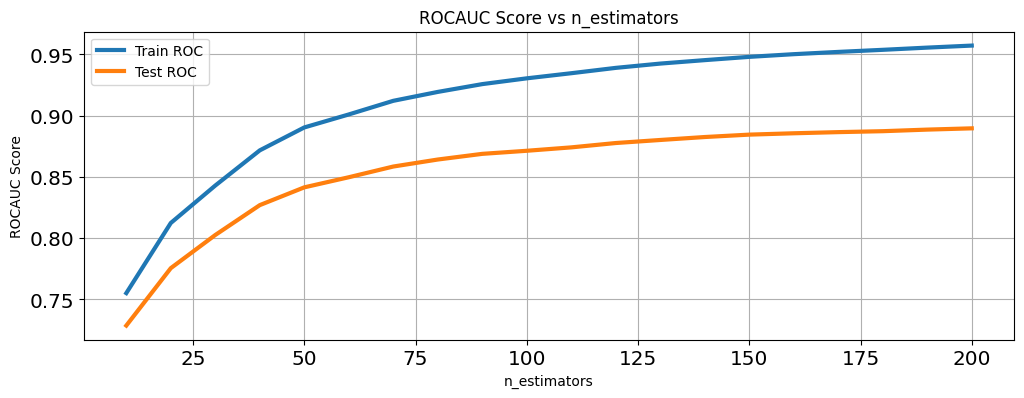

In [ ]:
n_estimators = [int(x) for x in np.linspace(10, 200, 20)]
draw_xgb_curve_n_estimators(n_estimators)

tidak ada perbedaan, tidak perlu tuning

### Learning Curve depth

In [ ]:
def draw_xgb_curve_depth(max_depth):
    train_recall_scores = []
    test_recall_scores = []
    train_roc_scores = []
    test_roc_scores = []

    for i in max_depth:
        model = XGBClassifier(verbose=0, max_depth=i, random_state=42)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

        # Recall
        train_recall = recall_score(y_train, y_train_pred)
        test_recall = recall_score(y_test, y_test_pred)
        train_recall_scores.append(train_recall)
        test_recall_scores.append(test_recall)

        # ROCAUC-score
        train_roc = roc_auc_score(y_train, y_pred_proba_train)
        test_roc = roc_auc_score(y_test, y_pred_proba_test)
        train_roc_scores.append(train_roc)
        test_roc_scores.append(test_roc)

        print(f'max_depth: {i:}; Recall Train: {train_recall:.4f}, Test: {test_recall:.4f}; '
              f'ROCAUC Train: {train_roc:.4f}, Test: {test_roc:.4f}')

    # Plot Recall
    plt.figure()
    plt.plot(max_depth, train_recall_scores, label='Train Recall')
    plt.plot(max_depth, test_recall_scores, label='Test Recall')
    plt.xlabel('max_depth')
    plt.ylabel('Recall Score')
    plt.title('Recall vs max_depth')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC-score
    plt.figure()
    plt.plot(max_depth, train_roc_scores, label='Train ROC')
    plt.plot(max_depth, test_roc_scores, label='Test ROC')
    plt.xlabel('max_depth')
    plt.ylabel('ROCAUC Score')
    plt.title('ROCAUC Score vs max_depth')
    plt.legend()
    plt.grid(True)
    plt.show()

max_depth: 2; Recall Train: 0.6272, Test: 0.6078; ROCAUC Train: 0.6785, Test: 0.6600
max_depth: 3; Recall Train: 0.6781, Test: 0.6527; ROCAUC Train: 0.7416, Test: 0.7130
max_depth: 4; Recall Train: 0.7594, Test: 0.7295; ROCAUC Train: 0.8264, Test: 0.7863
max_depth: 6; Recall Train: 0.8696, Test: 0.8174; ROCAUC Train: 0.9305, Test: 0.8713
max_depth: 7; Recall Train: 0.9055, Test: 0.8264; ROCAUC Train: 0.9537, Test: 0.8905
max_depth: 9; Recall Train: 0.9794, Test: 0.8313; ROCAUC Train: 0.9718, Test: 0.9080
max_depth: 10; Recall Train: 0.9928, Test: 0.8329; ROCAUC Train: 0.9748, Test: 0.9136
max_depth: 12; Recall Train: 0.9996, Test: 0.8339; ROCAUC Train: 0.9801, Test: 0.9194
max_depth: 13; Recall Train: 0.9993, Test: 0.8337; ROCAUC Train: 0.9816, Test: 0.9203
max_depth: 15; Recall Train: 0.9992, Test: 0.8300; ROCAUC Train: 0.9837, Test: 0.9206


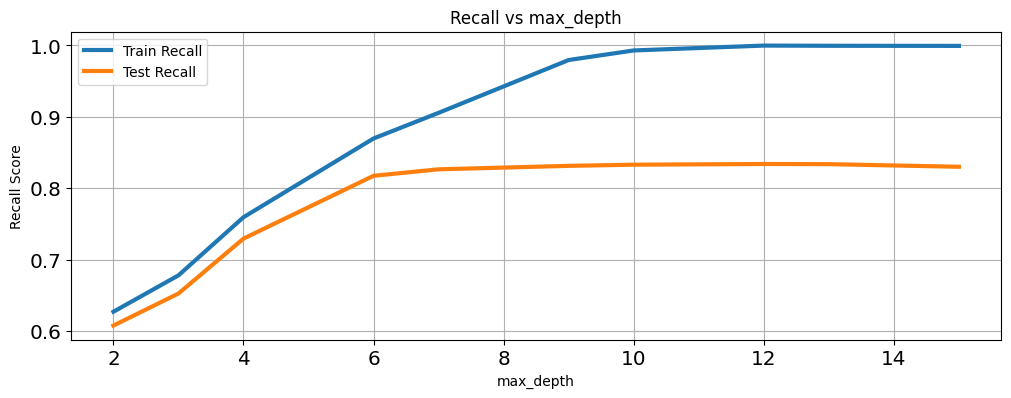

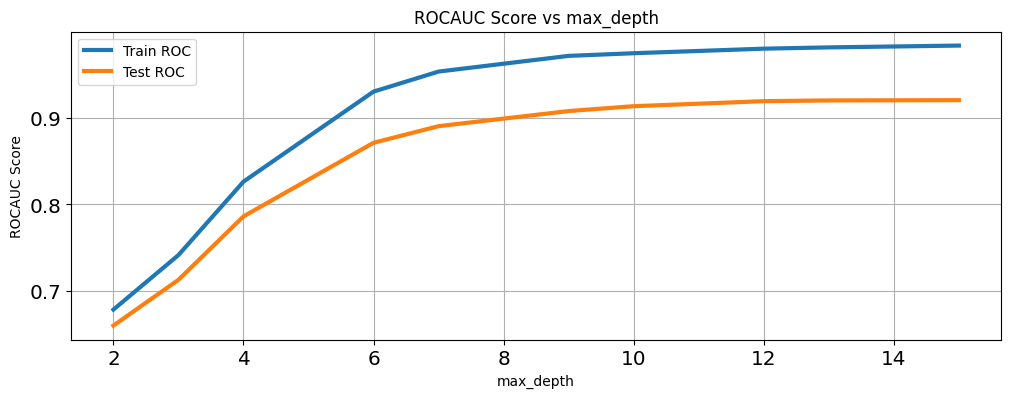

In [ ]:
max_depth = [int(x) for x in np.linspace(2, 15, 10)]
draw_xgb_curve_depth(max_depth)

depth = 6

### Learning Curve min_child_weight

In [ ]:
def draw_xgb_curve_min_child_weight(min_child_weight):
    train_recall_scores = []
    test_recall_scores = []
    train_roc_scores = []
    test_roc_scores = []

    for i in min_child_weight:
        model = XGBClassifier(verbose=0, max_depth=6, min_child_weight=i, random_state=42)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

        # Recall
        train_recall = recall_score(y_train, y_train_pred)
        test_recall = recall_score(y_test, y_test_pred)
        train_recall_scores.append(train_recall)
        test_recall_scores.append(test_recall)

        # ROCAUC-score
        train_roc = roc_auc_score(y_train, y_pred_proba_train)
        test_roc = roc_auc_score(y_test, y_pred_proba_test)
        train_roc_scores.append(train_roc)
        test_roc_scores.append(test_roc)

        print(f'min_child_weight: {i:}; Recall Train: {train_recall:.4f}, Test: {test_recall:.4f}; '
              f'ROCAUC Train: {train_roc:.4f}, Test: {test_roc:.4f}')

    # Plot Recall
    plt.figure()
    plt.plot(min_child_weight, train_recall_scores, label='Train Recall')
    plt.plot(min_child_weight, test_recall_scores, label='Test Recall')
    plt.xlabel('min_child_weight')
    plt.ylabel('Recall Score')
    plt.title('Recall vs min_child_weight')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC-score
    plt.figure()
    plt.plot(min_child_weight, train_roc_scores, label='Train ROC')
    plt.plot(min_child_weight, test_roc_scores, label='Test ROC')
    plt.xlabel('min_child_weight')
    plt.ylabel('ROCAUC Score')
    plt.title('ROCAUC Score vs min_child_weight')
    plt.legend()
    plt.grid(True)
    plt.show()

min_child_weight: 1; Recall Train: 0.8696, Test: 0.8174; ROCAUC Train: 0.9305, Test: 0.8713
min_child_weight: 6; Recall Train: 0.8547, Test: 0.8154; ROCAUC Train: 0.9198, Test: 0.8667
min_child_weight: 11; Recall Train: 0.8527, Test: 0.8111; ROCAUC Train: 0.9162, Test: 0.8648
min_child_weight: 16; Recall Train: 0.8482, Test: 0.8154; ROCAUC Train: 0.9076, Test: 0.8605
min_child_weight: 21; Recall Train: 0.8414, Test: 0.8090; ROCAUC Train: 0.9064, Test: 0.8585
min_child_weight: 27; Recall Train: 0.8388, Test: 0.8072; ROCAUC Train: 0.8982, Test: 0.8529
min_child_weight: 32; Recall Train: 0.8366, Test: 0.7984; ROCAUC Train: 0.8960, Test: 0.8493
min_child_weight: 37; Recall Train: 0.8291, Test: 0.7999; ROCAUC Train: 0.8895, Test: 0.8468
min_child_weight: 42; Recall Train: 0.8251, Test: 0.7921; ROCAUC Train: 0.8874, Test: 0.8436
min_child_weight: 47; Recall Train: 0.8230, Test: 0.7910; ROCAUC Train: 0.8844, Test: 0.8403
min_child_weight: 53; Recall Train: 0.8164, Test: 0.7871; ROCAUC Train: 

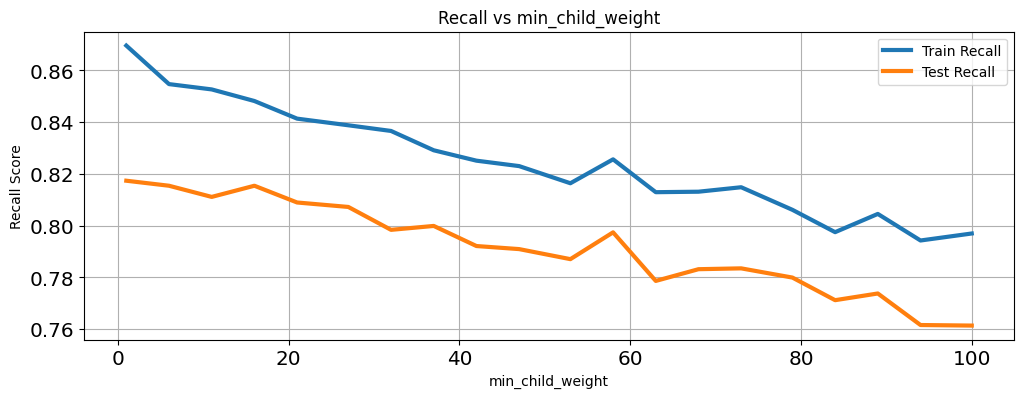

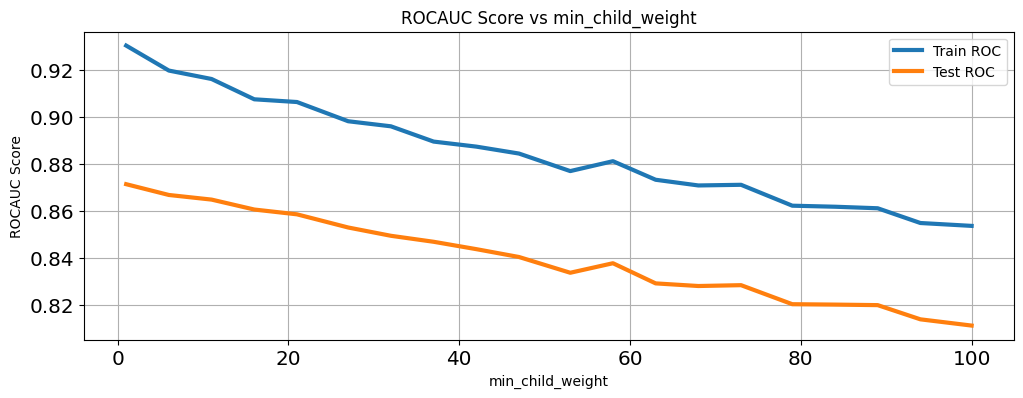

In [ ]:
min_child_weight = [int(x) for x in np.linspace(1, 100, 20)]
draw_xgb_curve_min_child_weight(min_child_weight)

min_child_weight tidak perlu tuning

### Learning Curve gamma

In [ ]:
def draw_xgb_curve_gamma(gamma):
    train_recall_scores = []
    test_recall_scores = []
    train_roc_scores = []
    test_roc_scores = []

    for i in gamma:
        model = XGBClassifier(verbose=0, max_depth=6, gamma=i, random_state=42)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

        # Recall
        train_recall = recall_score(y_train, y_train_pred)
        test_recall = recall_score(y_test, y_test_pred)
        train_recall_scores.append(train_recall)
        test_recall_scores.append(test_recall)

        # ROCAUC-score
        train_roc = roc_auc_score(y_train, y_pred_proba_train)
        test_roc = roc_auc_score(y_test, y_pred_proba_test)
        train_roc_scores.append(train_roc)
        test_roc_scores.append(test_roc)

        print(f'gamma: {i:}; Recall Train: {train_recall:.4f}, Test: {test_recall:.4f}; '
              f'ROCAUC Train: {train_roc:.4f}, Test: {test_roc:.4f}')

    # Plot Recall
    plt.figure()
    plt.plot(gamma, train_recall_scores, label='Train Recall')
    plt.plot(gamma, test_recall_scores, label='Test Recall')
    plt.xlabel('gamma')
    plt.ylabel('Recall Score')
    plt.title('Recall vs gamma')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC-score
    plt.figure()
    plt.plot(gamma, train_roc_scores, label='Train ROC')
    plt.plot(gamma, test_roc_scores, label='Test ROC')
    plt.xlabel('gamma')
    plt.ylabel('ROCAUC Score')
    plt.title('ROCAUC Score vs gamma')
    plt.legend()
    plt.grid(True)
    plt.show()

gamma: 1; Recall Train: 0.8064, Test: 0.7695; ROCAUC Train: 0.8730, Test: 0.8279
gamma: 6; Recall Train: 0.7089, Test: 0.6906; ROCAUC Train: 0.7705, Test: 0.7430
gamma: 11; Recall Train: 0.6961, Test: 0.6786; ROCAUC Train: 0.7443, Test: 0.7174
gamma: 16; Recall Train: 0.6556, Test: 0.6319; ROCAUC Train: 0.7221, Test: 0.6963
gamma: 21; Recall Train: 0.6663, Test: 0.6504; ROCAUC Train: 0.7090, Test: 0.6880
gamma: 27; Recall Train: 0.6647, Test: 0.6485; ROCAUC Train: 0.6903, Test: 0.6731
gamma: 32; Recall Train: 0.6646, Test: 0.6490; ROCAUC Train: 0.6776, Test: 0.6624
gamma: 37; Recall Train: 0.6445, Test: 0.6343; ROCAUC Train: 0.6664, Test: 0.6537
gamma: 42; Recall Train: 0.6260, Test: 0.6098; ROCAUC Train: 0.6612, Test: 0.6480
gamma: 47; Recall Train: 0.6258, Test: 0.6118; ROCAUC Train: 0.6518, Test: 0.6399
gamma: 53; Recall Train: 0.6522, Test: 0.6393; ROCAUC Train: 0.6523, Test: 0.6383
gamma: 58; Recall Train: 0.6217, Test: 0.6089; ROCAUC Train: 0.6475, Test: 0.6346
gamma: 63; Recall 

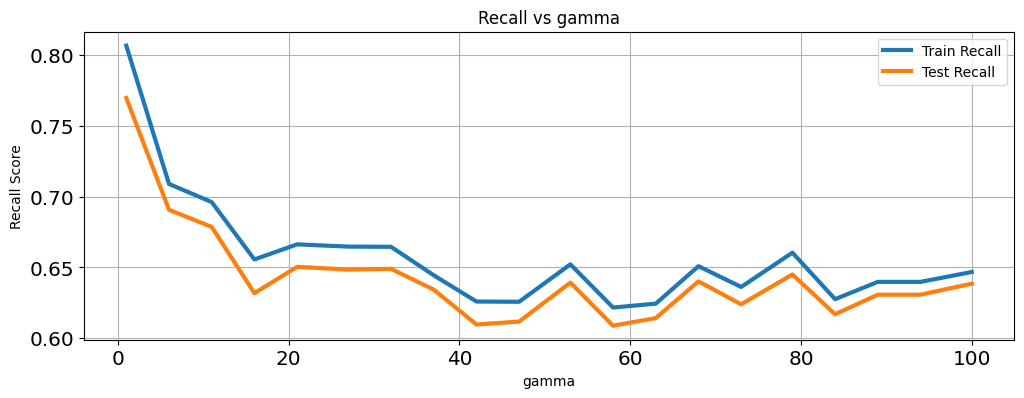

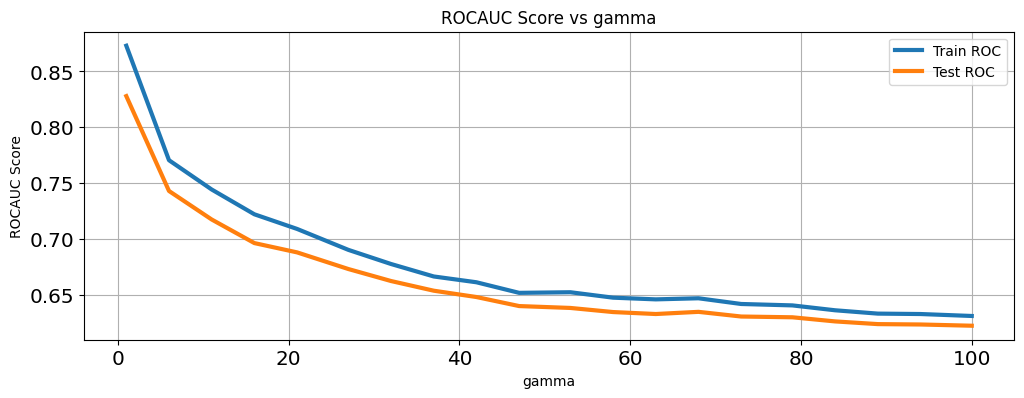

In [ ]:
gamma=  [int(x) for x in np.linspace(1, 100, 20)]
draw_xgb_curve_gamma(gamma)

gamma tidak perlu tuning

### Learning Curve subsample

In [ ]:
def draw_xgb_curve_subsample(subsample):
    train_recall_scores = []
    test_recall_scores = []
    train_roc_scores = []
    test_roc_scores = []

    for i in subsample:
        model = XGBClassifier(verbose=0, max_depth=6, subsample=i, random_state=42)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

        # Recall
        train_recall = recall_score(y_train, y_train_pred)
        test_recall = recall_score(y_test, y_test_pred)
        train_recall_scores.append(train_recall)
        test_recall_scores.append(test_recall)

        # ROCAUC-score
        train_roc = roc_auc_score(y_train, y_pred_proba_train)
        test_roc = roc_auc_score(y_test, y_pred_proba_test)
        train_roc_scores.append(train_roc)
        test_roc_scores.append(test_roc)

        print(f'subsample: {i:}; Recall Train: {train_recall:.4f}, Test: {test_recall:.4f}; '
              f'ROCAUC Train: {train_roc:.4f}, Test: {test_roc:.4f}')

    # Plot Recall
    plt.figure()
    plt.plot(subsample, train_recall_scores, label='Train Recall')
    plt.plot(subsample, test_recall_scores, label='Test Recall')
    plt.xlabel('subsample')
    plt.ylabel('Recall Score')
    plt.title('Recall vs subsample')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC-score
    plt.figure()
    plt.plot(subsample, train_roc_scores, label='Train ROC')
    plt.plot(subsample, test_roc_scores, label='Test ROC')
    plt.xlabel('subsample')
    plt.ylabel('ROCAUC Score')
    plt.title('ROCAUC Score vs subsample')
    plt.legend()
    plt.grid(True)
    plt.show()

subsample: 0.2; Recall Train: 0.8353, Test: 0.7975; ROCAUC Train: 0.8947, Test: 0.8437
subsample: 0.2888888888888889; Recall Train: 0.8464, Test: 0.7999; ROCAUC Train: 0.9082, Test: 0.8545
subsample: 0.37777777777777777; Recall Train: 0.8555, Test: 0.8147; ROCAUC Train: 0.9173, Test: 0.8644
subsample: 0.4666666666666667; Recall Train: 0.8594, Test: 0.8107; ROCAUC Train: 0.9198, Test: 0.8635
subsample: 0.5555555555555556; Recall Train: 0.8614, Test: 0.8158; ROCAUC Train: 0.9250, Test: 0.8710
subsample: 0.6444444444444445; Recall Train: 0.8648, Test: 0.8150; ROCAUC Train: 0.9268, Test: 0.8680
subsample: 0.7333333333333334; Recall Train: 0.8681, Test: 0.8184; ROCAUC Train: 0.9278, Test: 0.8706
subsample: 0.8222222222222222; Recall Train: 0.8662, Test: 0.8151; ROCAUC Train: 0.9281, Test: 0.8698
subsample: 0.9111111111111112; Recall Train: 0.8731, Test: 0.8190; ROCAUC Train: 0.9313, Test: 0.8737
subsample: 1.0; Recall Train: 0.8696, Test: 0.8174; ROCAUC Train: 0.9305, Test: 0.8713


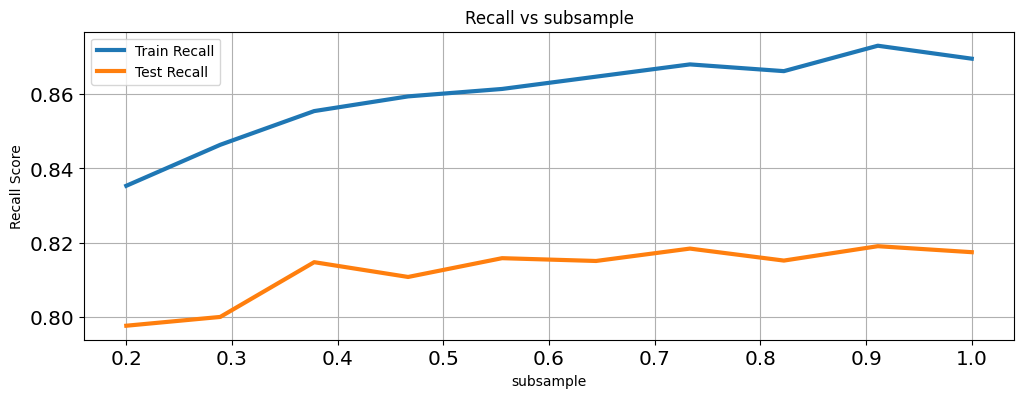

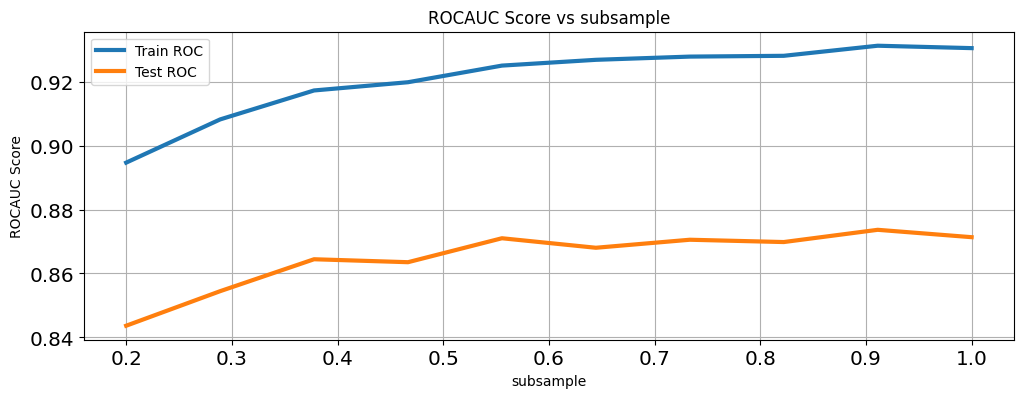

In [ ]:
subsample= np.linspace(0.2, 1, 10).tolist()
draw_xgb_curve_subsample(subsample)

subsumple = 1, sesuai tidak perlu tuning

### Learning Curve colsample_bytree

In [ ]:
def draw_xgb_curve_colsample_bytree(colsample_bytree):
    train_recall_scores = []
    test_recall_scores = []
    train_roc_scores = []
    test_roc_scores = []

    for i in colsample_bytree:
        model = XGBClassifier(verbose=0, max_depth=6, colsample_bytree=i, random_state=42)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

        # Recall
        train_recall = recall_score(y_train, y_train_pred)
        test_recall = recall_score(y_test, y_test_pred)
        train_recall_scores.append(train_recall)
        test_recall_scores.append(test_recall)

        # ROCAUC-score
        train_roc = roc_auc_score(y_train, y_pred_proba_train)
        test_roc = roc_auc_score(y_test, y_pred_proba_test)
        train_roc_scores.append(train_roc)
        test_roc_scores.append(test_roc)

        print(f'colsample_bytree: {i:}; Recall Train: {train_recall:.4f}, Test: {test_recall:.4f}; '
              f'ROCAUC Train: {train_roc:.4f}, Test: {test_roc:.4f}')

    # Plot Recall
    plt.figure()
    plt.plot(colsample_bytree, train_recall_scores, label='Train Recall')
    plt.plot(colsample_bytree, test_recall_scores, label='Test Recall')
    plt.xlabel('colsample_bytree')
    plt.ylabel('Recall Score')
    plt.title('Recall vs colsample_bytree')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC-score
    plt.figure()
    plt.plot(colsample_bytree, train_roc_scores, label='Train ROC')
    plt.plot(colsample_bytree, test_roc_scores, label='Test ROC')
    plt.xlabel('colsample_bytree')
    plt.ylabel('ROCAUC Score')
    plt.title('ROCAUC Score vs colsample_bytree')
    plt.legend()
    plt.grid(True)
    plt.show()

colsample_bytree: 0.2; Recall Train: 0.7545, Test: 0.7211; ROCAUC Train: 0.8148, Test: 0.7724
colsample_bytree: 0.2888888888888889; Recall Train: 0.8170, Test: 0.7804; ROCAUC Train: 0.8688, Test: 0.8218
colsample_bytree: 0.37777777777777777; Recall Train: 0.8303, Test: 0.7859; ROCAUC Train: 0.8893, Test: 0.8368
colsample_bytree: 0.4666666666666667; Recall Train: 0.8457, Test: 0.7973; ROCAUC Train: 0.9121, Test: 0.8576
colsample_bytree: 0.5555555555555556; Recall Train: 0.8513, Test: 0.8050; ROCAUC Train: 0.9168, Test: 0.8622
colsample_bytree: 0.6444444444444445; Recall Train: 0.8579, Test: 0.8081; ROCAUC Train: 0.9209, Test: 0.8640
colsample_bytree: 0.7333333333333334; Recall Train: 0.8635, Test: 0.8152; ROCAUC Train: 0.9220, Test: 0.8653
colsample_bytree: 0.8222222222222222; Recall Train: 0.8621, Test: 0.8098; ROCAUC Train: 0.9223, Test: 0.8666
colsample_bytree: 0.9111111111111112; Recall Train: 0.8642, Test: 0.8121; ROCAUC Train: 0.9261, Test: 0.8690
colsample_bytree: 1.0; Recall Tra

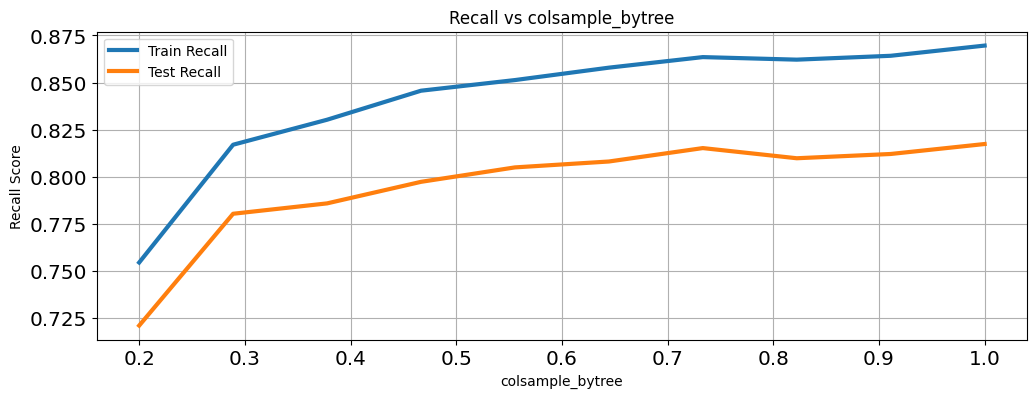

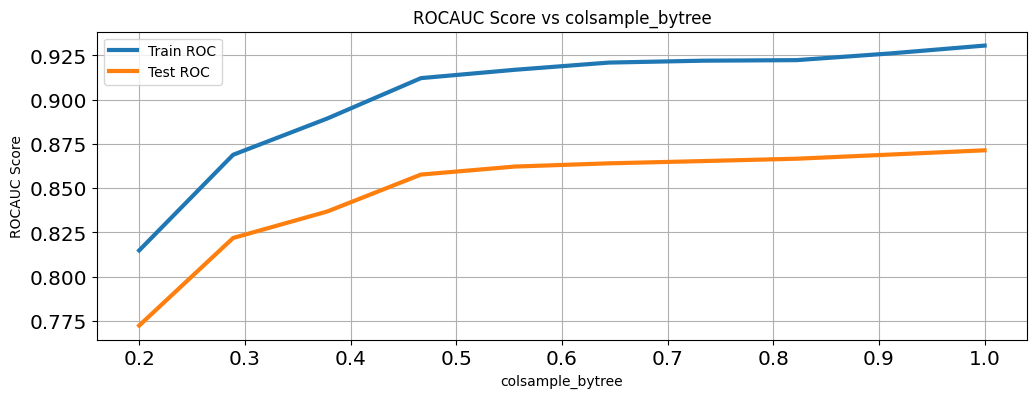

In [ ]:
colsample_bytree= np.linspace(0.2, 1, 10).tolist()
draw_xgb_curve_colsample_bytree(colsample_bytree)

colsample_bytree = 1, sesuai tidak perlu tuning

### Learning Curve reg_alpha

In [ ]:
def draw_xgb_curve_reg_alpha(reg_alpha):
    train_recall_scores = []
    test_recall_scores = []
    train_roc_scores = []
    test_roc_scores = []

    for i in reg_alpha:
        model = XGBClassifier(verbose=0, max_depth=6, reg_alpha=i, random_state=42)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

        # Recall
        train_recall = recall_score(y_train, y_train_pred)
        test_recall = recall_score(y_test, y_test_pred)
        train_recall_scores.append(train_recall)
        test_recall_scores.append(test_recall)

        # ROCAUC-score
        train_roc = roc_auc_score(y_train, y_pred_proba_train)
        test_roc = roc_auc_score(y_test, y_pred_proba_test)
        train_roc_scores.append(train_roc)
        test_roc_scores.append(test_roc)

        print(f'reg_alpha: {i:}; Recall Train: {train_recall:.4f}, Test: {test_recall:.4f}; '
              f'ROCAUC Train: {train_roc:.4f}, Test: {test_roc:.4f}')

    # Plot Recall
    plt.figure()
    plt.plot(reg_alpha, train_recall_scores, label='Train Recall')
    plt.plot(reg_alpha, test_recall_scores, label='Test Recall')
    plt.xlabel('reg_alpha')
    plt.ylabel('Recall Score')
    plt.title('Recall vs reg_alpha')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC-score
    plt.figure()
    plt.plot(reg_alpha, train_roc_scores, label='Train ROC')
    plt.plot(reg_alpha, test_roc_scores, label='Test ROC')
    plt.xlabel('reg_alpha')
    plt.ylabel('ROCAUC Score')
    plt.title('ROCAUC Score vs reg_alpha')
    plt.legend()
    plt.grid(True)
    plt.show()

reg_alpha: 1; Recall Train: 0.8700, Test: 0.8190; ROCAUC Train: 0.9294, Test: 0.8709
reg_alpha: 6; Recall Train: 0.8572, Test: 0.8202; ROCAUC Train: 0.9208, Test: 0.8709
reg_alpha: 11; Recall Train: 0.8456, Test: 0.8106; ROCAUC Train: 0.9109, Test: 0.8623
reg_alpha: 16; Recall Train: 0.8334, Test: 0.7964; ROCAUC Train: 0.8999, Test: 0.8548
reg_alpha: 21; Recall Train: 0.8271, Test: 0.7960; ROCAUC Train: 0.8908, Test: 0.8469
reg_alpha: 27; Recall Train: 0.8210, Test: 0.7901; ROCAUC Train: 0.8804, Test: 0.8390
reg_alpha: 32; Recall Train: 0.7967, Test: 0.7600; ROCAUC Train: 0.8551, Test: 0.8131
reg_alpha: 37; Recall Train: 0.7585, Test: 0.7279; ROCAUC Train: 0.8281, Test: 0.7915
reg_alpha: 42; Recall Train: 0.7293, Test: 0.7006; ROCAUC Train: 0.7934, Test: 0.7584
reg_alpha: 47; Recall Train: 0.7123, Test: 0.6894; ROCAUC Train: 0.7778, Test: 0.7460
reg_alpha: 53; Recall Train: 0.6730, Test: 0.6526; ROCAUC Train: 0.7412, Test: 0.7121
reg_alpha: 58; Recall Train: 0.6715, Test: 0.6531; ROCAU

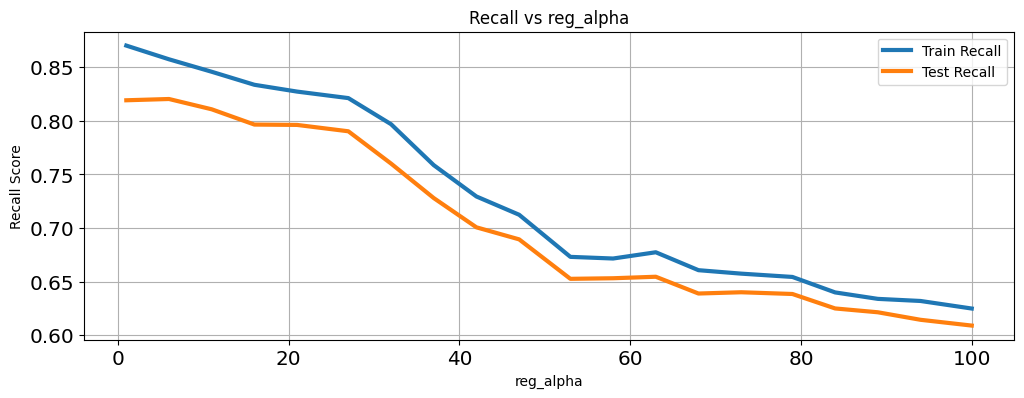

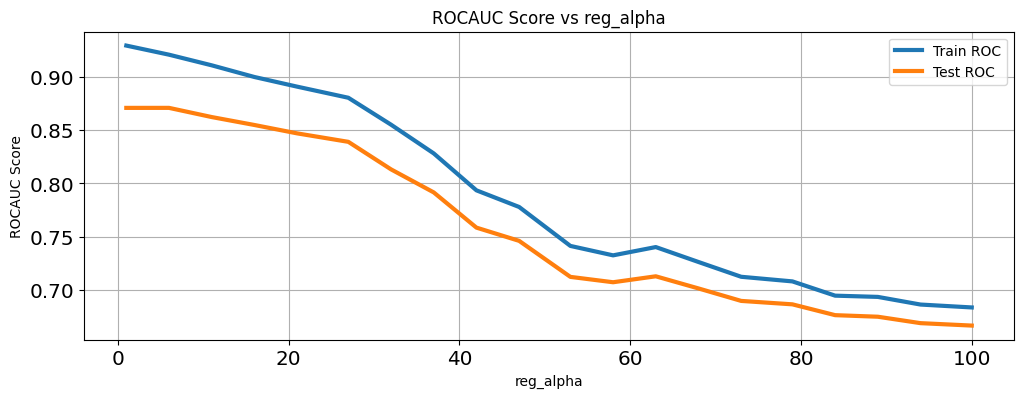

In [ ]:
reg_alpha=  [int(x) for x in np.linspace(1, 100, 20)]
draw_xgb_curve_reg_alpha(reg_alpha)

reg_alpha tidak perlu tuning

### Learning Curve reg_lambda

In [ ]:
def draw_xgb_curve_reg_lambda(reg_lambda):
    train_recall_scores = []
    test_recall_scores = []
    train_roc_scores = []
    test_roc_scores = []

    for i in reg_lambda:
        model = XGBClassifier(verbose=0, max_depth=6, reg_lambda=i, random_state=42)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

        # Recall
        train_recall = recall_score(y_train, y_train_pred)
        test_recall = recall_score(y_test, y_test_pred)
        train_recall_scores.append(train_recall)
        test_recall_scores.append(test_recall)

        # ROCAUC-score
        train_roc = roc_auc_score(y_train, y_pred_proba_train)
        test_roc = roc_auc_score(y_test, y_pred_proba_test)
        train_roc_scores.append(train_roc)
        test_roc_scores.append(test_roc)

        print(f'reg_lambda: {i:}; Recall Train: {train_recall:.4f}, Test: {test_recall:.4f}; '
              f'ROCAUC Train: {train_roc:.4f}, Test: {test_roc:.4f}')

    # Plot Recall
    plt.figure()
    plt.plot(reg_lambda, train_recall_scores, label='Train Recall')
    plt.plot(reg_lambda, test_recall_scores, label='Test Recall')
    plt.xlabel('reg_lambda')
    plt.ylabel('Recall Score')
    plt.title('Recall vs reg_lambda')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC-score
    plt.figure()
    plt.plot(reg_lambda, train_roc_scores, label='Train ROC')
    plt.plot(reg_lambda, test_roc_scores, label='Test ROC')
    plt.xlabel('reg_lambda')
    plt.ylabel('ROCAUC Score')
    plt.title('ROCAUC Score vs reg_lambda')
    plt.legend()
    plt.grid(True)
    plt.show()



reg_lambda: 1; Recall Train: 0.8696, Test: 0.8174; ROCAUC Train: 0.9305, Test: 0.8713
reg_lambda: 6; Recall Train: 0.8594, Test: 0.8139; ROCAUC Train: 0.9221, Test: 0.8689
reg_lambda: 11; Recall Train: 0.8507, Test: 0.8107; ROCAUC Train: 0.9180, Test: 0.8670
reg_lambda: 16; Recall Train: 0.8515, Test: 0.8157; ROCAUC Train: 0.9136, Test: 0.8659
reg_lambda: 21; Recall Train: 0.8444, Test: 0.8089; ROCAUC Train: 0.9077, Test: 0.8597
reg_lambda: 27; Recall Train: 0.8318, Test: 0.7992; ROCAUC Train: 0.9025, Test: 0.8566
reg_lambda: 32; Recall Train: 0.8381, Test: 0.7968; ROCAUC Train: 0.9032, Test: 0.8542
reg_lambda: 37; Recall Train: 0.8357, Test: 0.8027; ROCAUC Train: 0.9011, Test: 0.8544
reg_lambda: 42; Recall Train: 0.8317, Test: 0.8016; ROCAUC Train: 0.8959, Test: 0.8510
reg_lambda: 47; Recall Train: 0.8324, Test: 0.8012; ROCAUC Train: 0.8962, Test: 0.8509
reg_lambda: 53; Recall Train: 0.8340, Test: 0.8030; ROCAUC Train: 0.8949, Test: 0.8490
reg_lambda: 58; Recall Train: 0.8326, Test: 0

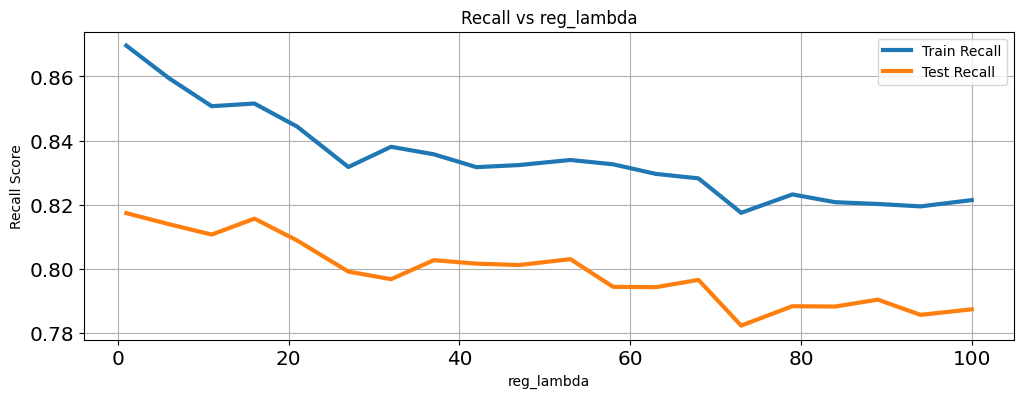

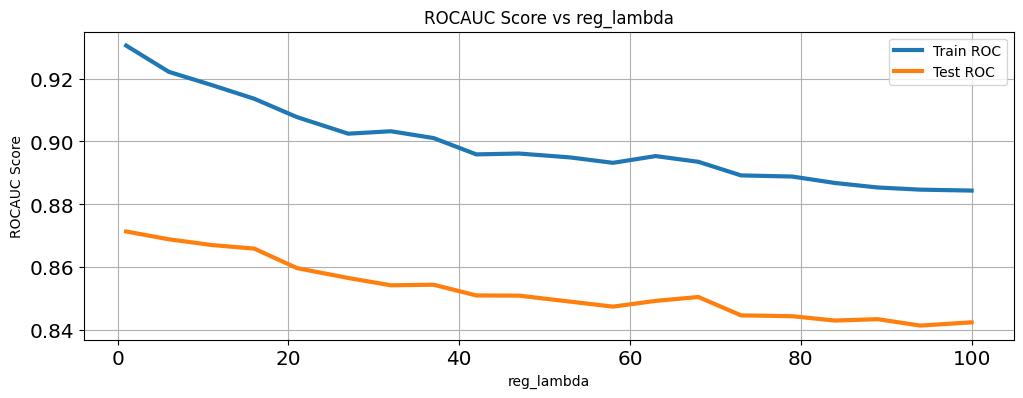

In [ ]:
reg_lambda=  [int(x) for x in np.linspace(1, 100, 20)]
draw_xgb_curve_reg_lambda(reg_lambda)

tidak perlu tuning

### Learning Curve learning_rate

In [ ]:
def draw_xgb_curve_learning_rate(learning_rate):
    train_recall_scores = []
    test_recall_scores = []
    train_roc_scores = []
    test_roc_scores = []

    for i in learning_rate:
        model = XGBClassifier(verbose=0, max_depth=6, learning_rate=i, random_state=42)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

        # Recall
        train_recall = recall_score(y_train, y_train_pred)
        test_recall = recall_score(y_test, y_test_pred)
        train_recall_scores.append(train_recall)
        test_recall_scores.append(test_recall)

        # ROCAUC-score
        train_roc = roc_auc_score(y_train, y_pred_proba_train)
        test_roc = roc_auc_score(y_test, y_pred_proba_test)
        train_roc_scores.append(train_roc)
        test_roc_scores.append(test_roc)

        print(f'learning_rate: {i:}; Recall Train: {train_recall:.4f}, Test: {test_recall:.4f}; '
              f'ROCAUC Train: {train_roc:.4f}, Test: {test_roc:.4f}')

    # Plot Recall
    plt.figure()
    plt.plot(learning_rate, train_recall_scores, label='Train Recall')
    plt.plot(learning_rate, test_recall_scores, label='Test Recall')
    plt.xlabel('learning_rate')
    plt.ylabel('Recall Score')
    plt.title('Recall vs learning_rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC-score
    plt.figure()
    plt.plot(learning_rate, train_roc_scores, label='Train ROC')
    plt.plot(learning_rate, test_roc_scores, label='Test ROC')
    plt.xlabel('learning_rate')
    plt.ylabel('ROCAUC Score')
    plt.title('ROCAUC Score vs learning_rate')
    plt.legend()
    plt.grid(True)
    plt.show()

learning_rate: 0.01; Recall Train: 0.6929, Test: 0.6675; ROCAUC Train: 0.7307, Test: 0.7058
learning_rate: 0.08666666666666666; Recall Train: 0.7944, Test: 0.7557; ROCAUC Train: 0.8600, Test: 0.8166
learning_rate: 0.16333333333333333; Recall Train: 0.8353, Test: 0.7873; ROCAUC Train: 0.9007, Test: 0.8502
learning_rate: 0.24; Recall Train: 0.8549, Test: 0.8094; ROCAUC Train: 0.9207, Test: 0.8642
learning_rate: 0.31666666666666665; Recall Train: 0.8696, Test: 0.8109; ROCAUC Train: 0.9302, Test: 0.8707
learning_rate: 0.3933333333333333; Recall Train: 0.8833, Test: 0.8248; ROCAUC Train: 0.9394, Test: 0.8756
learning_rate: 0.47; Recall Train: 0.8981, Test: 0.8287; ROCAUC Train: 0.9460, Test: 0.8797
learning_rate: 0.5466666666666666; Recall Train: 0.9061, Test: 0.8350; ROCAUC Train: 0.9502, Test: 0.8811
learning_rate: 0.6233333333333333; Recall Train: 0.9149, Test: 0.8380; ROCAUC Train: 0.9537, Test: 0.8829
learning_rate: 0.7; Recall Train: 0.9202, Test: 0.8375; ROCAUC Train: 0.9570, Test: 0

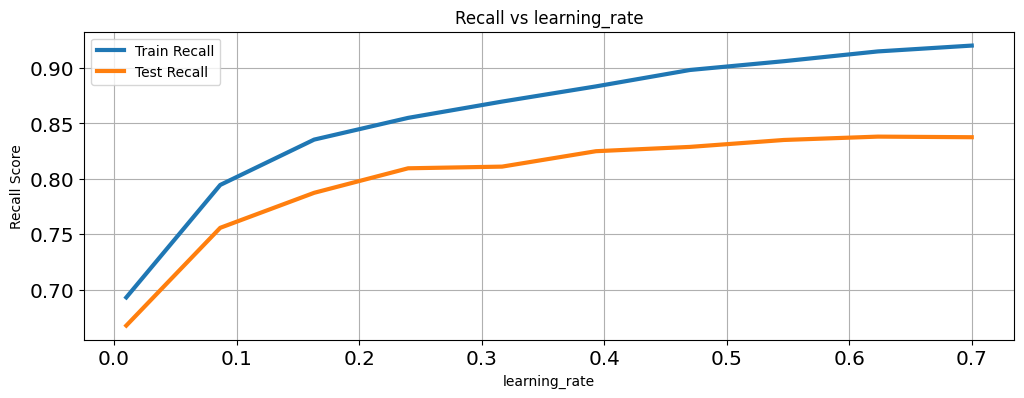

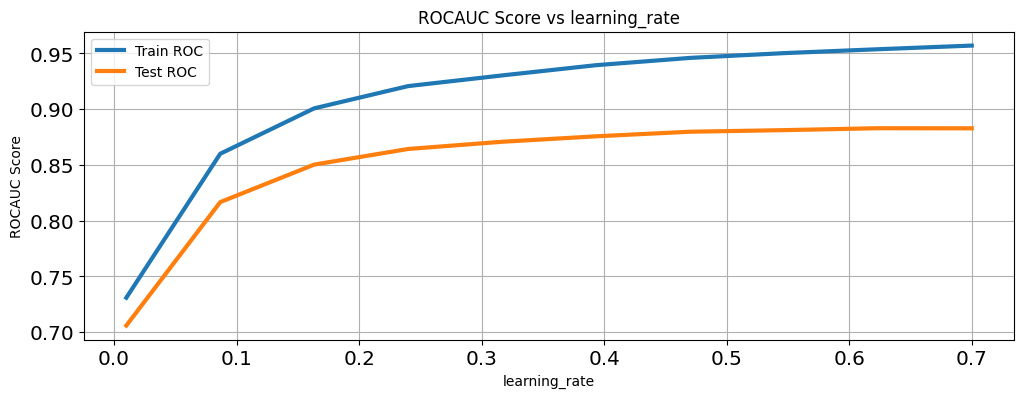

In [ ]:
learning_rate = np.linspace(0.01, 0.7, 10).tolist()
draw_xgb_curve_learning_rate(learning_rate)

learning_rate  = 0.546

## Xgboost After Tuning

In [69]:
xgb_tuning = XGBClassifier(verbose=0,learning_rate=0.546, random_state=42)

print(f'Evaluate model: XGBClassifier setelah tuning')
eval_classification_single(xgb_tuning)

Evaluate model: XGBClassifier setelah tuning
Recall (Train Set): 0.90
Recall (Test Set): 0.83
ROC-AUC (Train Set): 0.95
ROC-AUC (Test Set): 0.88
Recall (crossval train): 0.91
Recall (crossval test): 0.83


In [70]:
xgb_tuning.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.546,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'verbose': 0}

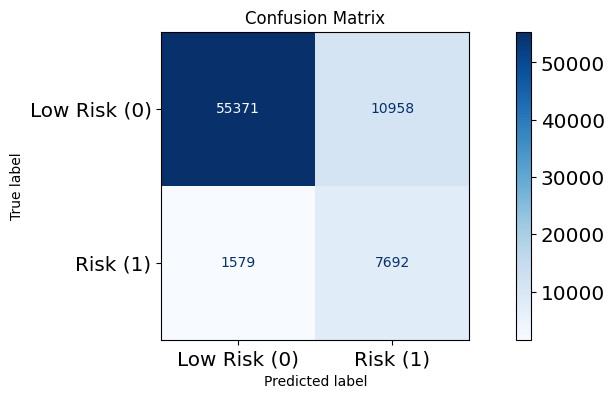

In [71]:
plot_confusion_matrix_and_metrics(xgb_tuning)

In [72]:
analyze_fp_fn_balance(xgb_tuning)

True Positives (TP): 7692 (10.17%)
True Negatives (TN): 55371 (73.24%)
False Positives (FP): 10958 (14.49%)
False Negatives (FN): 1579 (2.09%)

🔁 Balance between FP and FN (0 = perfect balance, 1 = completely unbalanced): 0.75


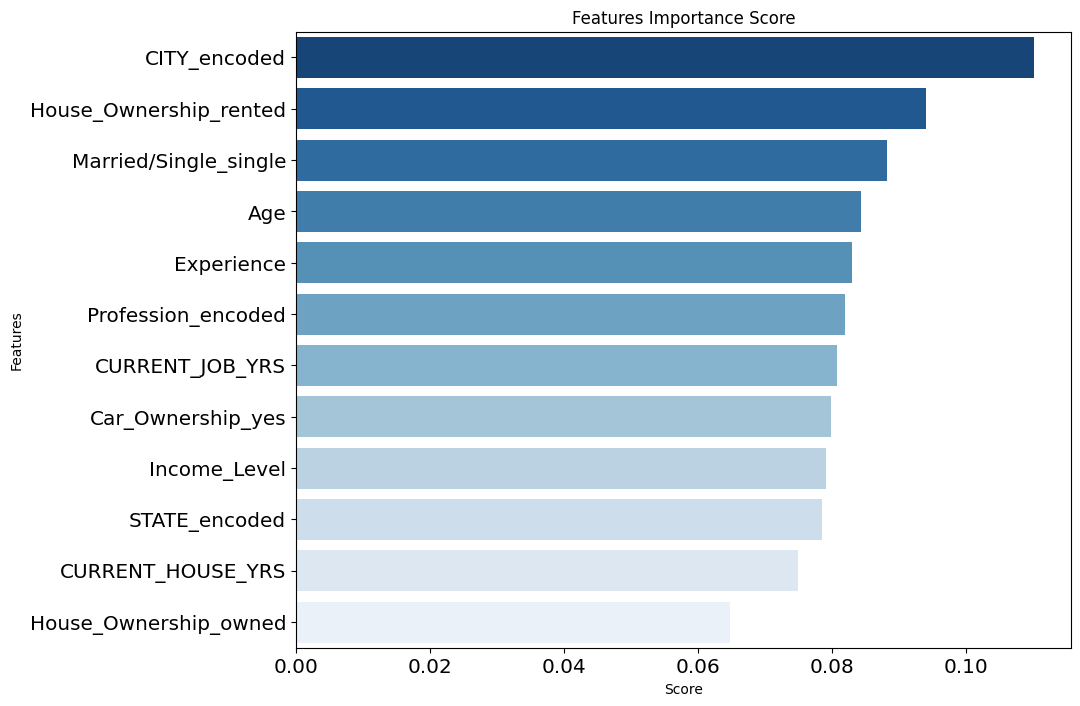

In [79]:
show_feature_importance(xgb_tuning)

In [ ]:
feat_importances = pd.Series(xgb_tuning.feature_importances_, index=X_test.columns)
feat_importances

,0
Age,0.084295
Experience,0.082953
CURRENT_JOB_YRS,0.080755
CURRENT_HOUSE_YRS,0.074946
Income_Level,0.079173
Car_Ownership_yes,0.079854
Married/Single_single,0.088314
House_Ownership_owned,0.064873
House_Ownership_rented,0.094005
Profession_encoded,0.082025


# SHAP

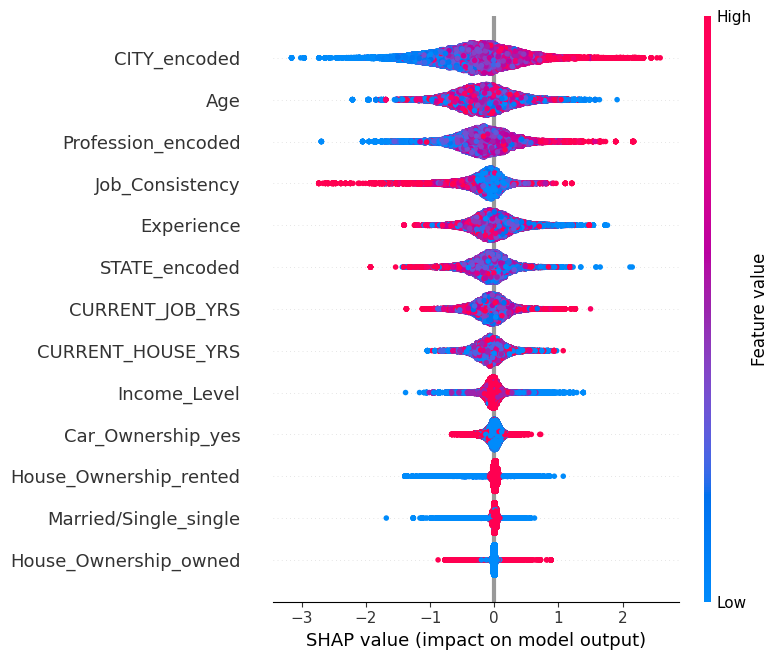

In [ ]:
import shap

explainer = shap.Explainer(xgb_tuning)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


# Result

In [ ]:
xgb_tuning = XGBClassifier(verbose=0,learning_rate=0.546, max_depth=6, subsample=1,colsample_bytree=1, random_state=42)
xgb_tuning.fit(X_train, y_train)
y_pred = xgb_tuning.predict(X_test)
X_test_before['Risk_Flag_Predicted'] = y_pred


In [ ]:
X_test_before

,Age,Experience,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Income_Level,Car_Ownership_yes,Married/Single_single,House_Ownership_owned,House_Ownership_rented,Risk_Flag_Predicted
75255,47,18,Politician,Hindupur,Andhra_Pradesh,7,13,3,False,True,False,True,0
192435,44,2,Computer_hardware_engineer,Narasaraopet,Andhra_Pradesh,2,10,3,False,True,False,True,0
154839,55,9,Software_Developer,Patna,Bihar,9,13,3,False,True,False,True,0
59774,61,20,Comedian,Haldia,West_Bengal,8,11,3,False,True,False,True,0
63788,78,13,Web_designer,Coimbatore,Tamil_Nadu,9,12,2,False,True,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148446,37,18,Chef,Shivpuri,Madhya_Pradesh,5,10,3,False,True,False,True,0
208441,58,17,Chartered_Accountant,Alappuzha,Kerala,10,10,2,False,True,False,True,0
137796,33,2,Army_officer,Shimoga,Karnataka,2,13,3,False,True,False,True,0
34679,57,12,Engineer,Kadapa[23],Andhra_Pradesh,12,10,3,False,True,False,True,1


In [ ]:
X_test_before.shape

(75600, 13)

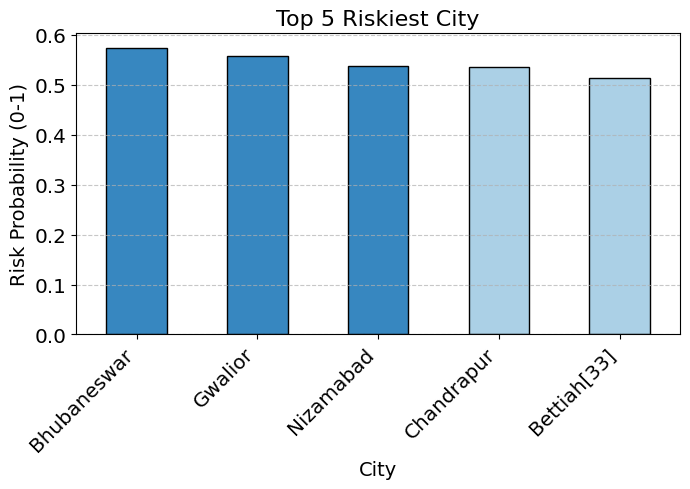

In [ ]:
# Top 5 Risky City
risk_by_state = X_test_before.groupby('CITY')['Risk_Flag_Predicted'].mean().sort_values(ascending=False)
colors = sns.color_palette("Blues")
top_risky_state = risk_by_state.head(5)

plt.figure(figsize=(7,5))
top_risky_state.plot(kind='bar', color=bar_colors, edgecolor='black')
plt.title('Top 5 Riskiest City', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Risk Probability (0-1)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

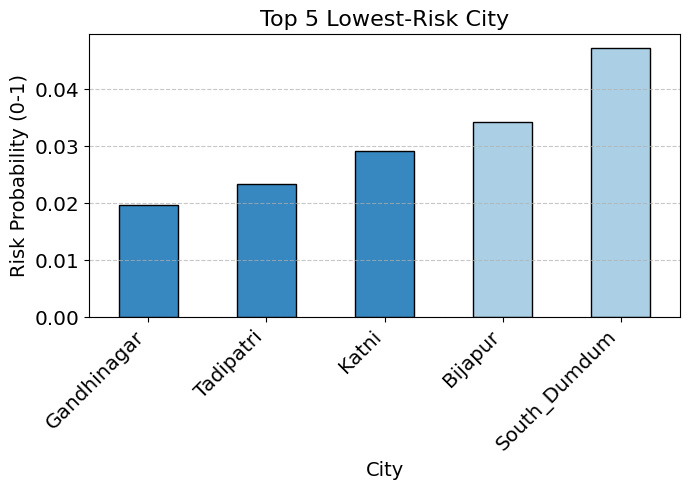

In [ ]:
# Top 5 Lowest Risk City
risk_by_state = X_test_before.groupby('CITY')['Risk_Flag_Predicted'].mean().sort_values(ascending=True)
colors = sns.color_palette("Blues")
top_risky_state = risk_by_state.head(5)

plt.figure(figsize=(7,5))
top_risky_state.plot(kind='bar', color=bar_colors, edgecolor='black')
plt.title('Top 5 Lowest-Risk City', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Risk Probability (0-1)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
X_test_before['Married/Single_single'] = X_test_before['Married/Single_single'].map({True: 'Single', False: 'Married'})

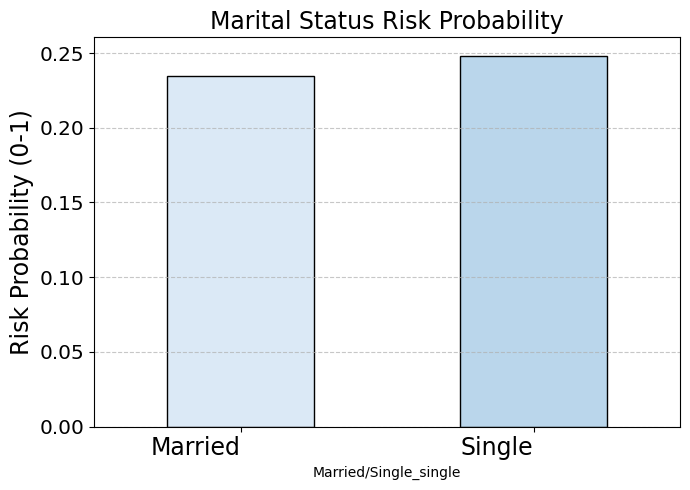

In [ ]:
risk_bystatus = X_test_before.groupby('Married/Single_single')['Risk_Flag_Predicted'].mean()
colors = sns.color_palette("Blues")

plt.figure(figsize=(7,5))
risk_bystatus.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Marital Status Risk Probability', fontsize=17)
plt.ylabel('Risk Probability (0-1)', fontsize=17)
plt.xticks(rotation=0, ha='right',fontsize=17)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
risk_bystatus = final_result.groupby('Married/Single_single')['Risk_Flag_Predicted'].mean()

# Risk Category

In [ ]:
X_test_before

,Age,Experience,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Income_Level,Car_Ownership_yes,Married/Single_single,House_Ownership_owned,House_Ownership_rented,Risk_Flag_Predicted
75255,47,18,Politician,Hindupur,Andhra_Pradesh,7,13,3,False,Single,False,True,0
192435,44,2,Computer_hardware_engineer,Narasaraopet,Andhra_Pradesh,2,10,3,False,Single,False,True,0
154839,55,9,Software_Developer,Patna,Bihar,9,13,3,False,Single,False,True,0
59774,61,20,Comedian,Haldia,West_Bengal,8,11,3,False,Single,False,True,0
63788,78,13,Web_designer,Coimbatore,Tamil_Nadu,9,12,2,False,Single,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148446,37,18,Chef,Shivpuri,Madhya_Pradesh,5,10,3,False,Single,False,True,0
208441,58,17,Chartered_Accountant,Alappuzha,Kerala,10,10,2,False,Single,False,True,0
137796,33,2,Army_officer,Shimoga,Karnataka,2,13,3,False,Single,False,True,0
34679,57,12,Engineer,Kadapa[23],Andhra_Pradesh,12,10,3,False,Single,False,True,1


In [ ]:
def analyze_risk_categories(model,filter_need_review=False):

    # Fit the model
    model.fit(X_train, y_train)

    # Predict probability of class 1 (risky)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Copy test data and add true labels and predicted probability
    result_df = X_test_before.copy()
    result_df['True_Label'] = y_test
    result_df['Probability'] = y_proba

    # Risk categorization logic
    def categorize(prob):
        if prob <= 0.3:
            return 'Not Risk'
        elif prob <= 0.6:
            return 'Need Review'
        else:
            return 'Risk'

    result_df['Risk_Category'] = result_df['Probability'].apply(categorize)

    # Optional filter
    if filter_need_review:
        result_df = result_df[result_df['Risk_Category'] == 'Need Review']

    return result_df

In [ ]:
# All test results with risk category
full_result = analyze_risk_categories(xgb_tuning)
full_result

,Age,Experience,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Income_Level,Car_Ownership_yes,Married/Single_single,House_Ownership_owned,House_Ownership_rented,Risk_Flag_Predicted,True_Label,Probability,Risk_Category
75255,47,18,Politician,Hindupur,Andhra_Pradesh,7,13,3,False,Single,False,True,0,0,0.473796,Need Review
192435,44,2,Computer_hardware_engineer,Narasaraopet,Andhra_Pradesh,2,10,3,False,Single,False,True,0,0,0.199207,Not Risk
154839,55,9,Software_Developer,Patna,Bihar,9,13,3,False,Single,False,True,0,0,0.080740,Not Risk
59774,61,20,Comedian,Haldia,West_Bengal,8,11,3,False,Single,False,True,0,0,0.236940,Not Risk
63788,78,13,Web_designer,Coimbatore,Tamil_Nadu,9,12,2,False,Single,False,True,0,0,0.165392,Not Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148446,37,18,Chef,Shivpuri,Madhya_Pradesh,5,10,3,False,Single,False,True,0,0,0.018654,Not Risk
208441,58,17,Chartered_Accountant,Alappuzha,Kerala,10,10,2,False,Single,False,True,0,0,0.019038,Not Risk
137796,33,2,Army_officer,Shimoga,Karnataka,2,13,3,False,Single,False,True,0,0,0.069731,Not Risk
34679,57,12,Engineer,Kadapa[23],Andhra_Pradesh,12,10,3,False,Single,False,True,1,1,0.761200,Risk


In [ ]:
full_result.value_counts('Risk_Category')

,count
Risk_Category,
Not Risk,47024
Risk,16034
Need Review,12542


In [ ]:
need_review_only = analyze_risk_categories(xgb_tuning, filter_need_review=True)
need_review_only

,Age,Experience,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Income_Level,Car_Ownership_yes,Married/Single_single,House_Ownership_owned,House_Ownership_rented,Risk_Flag_Predicted,True_Label,Probability,Risk_Category
75255,47,18,Politician,Hindupur,Andhra_Pradesh,7,13,3,False,Single,False,True,0,0,0.473796,Need Review
235462,49,13,Fashion_Designer,Korba,Chhattisgarh,13,14,3,False,Single,False,True,0,0,0.321735,Need Review
28320,29,0,Technician,Yamunanagar,Haryana,0,12,3,False,Single,False,True,0,0,0.449848,Need Review
56833,31,6,Civil_engineer,Mumbai,Maharashtra,6,10,3,False,Single,False,True,0,0,0.307279,Need Review
249828,66,6,Hotel_Manager,Kamarhati,West_Bengal,6,11,1,True,Single,False,True,1,0,0.594305,Need Review
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82716,53,5,Design_Engineer,Berhampur,Odisha,5,14,3,False,Single,False,True,0,0,0.437821,Need Review
132269,55,7,Artist,Hindupur,Andhra_Pradesh,7,12,2,False,Single,False,True,0,0,0.491644,Need Review
123720,35,15,Physician,Tadepalligudem,Andhra_Pradesh,5,13,3,False,Single,False,True,0,0,0.350879,Need Review
177483,57,3,Technical_writer,Kurnool[18],Andhra_Pradesh,3,12,3,False,Single,True,False,1,1,0.523536,Need Review


In [ ]:
need_review_only.shape

(12542, 16)

# Business Impact

Parameter business impact setelah penerapan machine learning berdasarkan:
* Approval Rate Optimization
* Assessment Rate Increase
* Non-Performing Loan (NPL) Reduction Rate
* Cycle Time Optimization

Perhitungan business impact menggunakan asumsi:
1. Perusahaan memiliki 150 credit analyst staff
2. Credit Analyst mampu menangani maksimal 15 personal loan application/day secara manual
3. Personal loan application mencapai 75600/month

In [ ]:
ca_sum = 150
ca_perday = 15
Loanapp_permonth = 75600

In [ ]:
TN = 55371
FN = 1579
FP = 10958
TP = 7692

In [ ]:
risk = 16304
need_review = 12542
not_risk = 47024

## Assessment Rate Increase

In [ ]:
# Total Monthly Capacity without ML
month_cap = ca_sum * ca_perday * 22
print(f'Total Monthly Capacity: {month_cap}')

# Percentage of loan applications that can be handled in one month wihout ML
handled_month = (month_cap / Loanapp_permonth)*100
print(f'Percentage of loan applications that can be handled in one month: {handled_month}')

Total Monthly Capacity: 49500
Percentage of loan applications that can be handled in one month: 65.47619047619048


In [ ]:
#After Implementing ML
Rate_Increase = round(((100 - handled_month)/handled_month*100),2)
print(f"Assessment Rate Increasing in {Rate_Increase}%")

Assessment Rate Increasing in 52.73%


## Cycle Time Reduction

In [ ]:
# Total Daily Capacity
day_cap = ca_sum * ca_perday
print(f'Total Daily Capacity: {day_cap}')

# Total workdays needed to process 75600 Loan manually
workdays = round((Loanapp_permonth / day_cap),2)
print(f'Total workdays needed to process 75600 loans manually: {workdays}')

# Total workdays needed to process 75600 Loan after ML
workdays_after = round((need_review / day_cap),2)
print(f'Total workdays needed to process 75600 loans after ML: {workdays_after}')

# Time Reduction
reduction = round((workdays-workdays_after)/workdays*100,2)
print(f'Time Reduction in {reduction}%')

Total Daily Capacity: 2250
Total workdays needed to process 75600 loans manually: 33.6
Total workdays needed to process 75600 loans after ML: 5.57
Time Reduction in 83.42%


## Approval Rate Optimization

In [ ]:
# In India, the average loan approval rate is 79%
app_rate_before = 0.79*month_cap
print(f'Total Approved Loan before implemented ML: {app_rate_before}')

# After Implemented
app_rate_after = TN+FN
print(f'Total Approved Loan after implemented ML: {app_rate_after}')

#Optimization
opt = round((app_rate_after-app_rate_before)/app_rate_before*100,2)
print(f'Approval Rate Optimization in {opt}%')

Total Approved Loan before implemented ML: 39105.0
Total Approved Loan after implemented ML: 56950
Approval Rate Optimization in 45.63%


## Non-Performing Loan Reduction Rate

In [ ]:
# Manual non-performing rate (industry average) is around 5%
totalnonper_before = 0.05*month_cap
non_per_rate_before = 5
print(f'Total Non-Performing Loan before implemented ML: {totalnonper_before}')
print(f'Presentase Non-Performing Loan before implemented ML: 5%')

# Non-performing rate after implemented ML
totalnonper_after = FN
non_per_rate_after = round(FN/(FN+TN+FP+TP)*100,2)
print(f'Total Non-Performing Loan after implemented ML: {totalnonper_after}')
print(f'Presentase Non-Performing Loan after implemented ML: {non_per_rate_after}%')

# Non-Performing Loan Reduction Rate
Reduc_rate = round((non_per_rate_before-non_per_rate_after)/non_per_rate_before*100,2)
print(f'Non-Performing Loan Reduction Rate in {Reduc_rate}%')

Total Non-Performing Loan before implemented ML: 2475.0
Presentase Non-Performing Loan before implemented ML: 5%
Total Non-Performing Loan after implemented ML: 1579
Presentase Non-Performing Loan after implemented ML: 2.09%
Non-Performing Loan Reduction Rate in 58.2%
